# training_models_large_data

## Training models when data doesn't fit in memory

At some point in your carreer in data science, you'll deal with some big dataset which will bring chaos to your otherwise clean workflow: pandas will crash with a `MemoryError`, all of the models in `sklearn` will seem useless as they need all of the data in RAM, as well as the coolest new methods you started to use, like `UMAP` (what did you expect? That the author would create a cutting edge ML algorithm *and* a distributed, out-of-memory implementation?).

You believe that distributed ML training can solve your problem. You start to do some digging and uncovers a multitude of words like Hadoop, Hive, Spark, Kubernetes and learn that they really *could* help you scale your models, but then you also learn that

1. Configuring clusters of machines is really hard. It's not a coincidence that Databricks is a huge business, and companies like Google, Amazon and Microsoft heavily invest in tools to scale ML. But even then, if you don't have DevOps / Software Engineering backgroud, even using cloud provider tools is not obvious

2. There's not a single, unified abstraction (like `sklearn`) for distributed ML training. Each library implements a different way to do it, and, given your platform, this may limit the set of algorithms you can use

Your deadline is approaching, you haven't scratched the surface on distributed computing, you can't seem to make `pyspark` work, and you start to worry and imagine if there's a quicker and may I say, *dirtier* approach.

And there is! And it is actually not dirty at all! In this post, I'll show some hacks to make your favorite model work in a single-node environment and a cool tool (dask) that will let you grasp distributed computation in your cozy python environment and with your well known pandas syntax. 

Please note: this is not a replacement for Spark, Kubernetes and other technologies. You should learn those too (they are very, very cool). But you should do it calmly. I hope that the tricks I'll show will expand the array of problems you can solve with a single machine, help you understand a little bit more of distributed computing, and buy you time to study other tools!

In [1]:
# basic
import sys
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

# better plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('bmh')

## Tracking memory usage 

We will build several ML pipelines and track their memory usage to see our tricks at work. In order to do this, I created a decorator that uses the `tracemalloc` and `concurrent` packages to sample memory usage in a function every 1 ms and return its results, drawing inspiration from this [post](https://medium.com/survata-engineering-blog/monitoring-memory-usage-of-a-running-python-program-49f027e3d1ba). You can check the full code [here]().

In [2]:
# importing custom memory tracking decorator
from track_memory import track_memory_use, plot_memory_use

## Data

For this example, we'll use the fraud detection dataset from [Synthetic Financial Datasets For Fraud Detection](https://www.kaggle.com/ntnu-testimon/paysim1) on Kaggle, with some feature engineering tricks borrowed from the Kaggle Kernel [Predicting Fraud in Financial Payment Services](https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services). The data is not huge and it actually fits in memory, but it's big enough so we can demonstrate memory usage gains with our tricks. 

We have two datasets: a big `train.csv` (80% of records) for model training and a small `test.csv` (20% of records) for model validation (for simplicity, we'll only use one validation set). The data invites a binary classification task to predict which transactions are fraudulent, given the amount transacted, source and destination balances, and other information.

## Naive implementation: A Tale of Memory Usage

Let us solve the fraud problem in a naive way and track memory usage. The first thing we usually do is to read the dataset with pandas. How much does this cost, memory-wise?

No handles with labels found to put in legend.


Current memory usage: 570.384648
Peak memory usage: 1140.471604


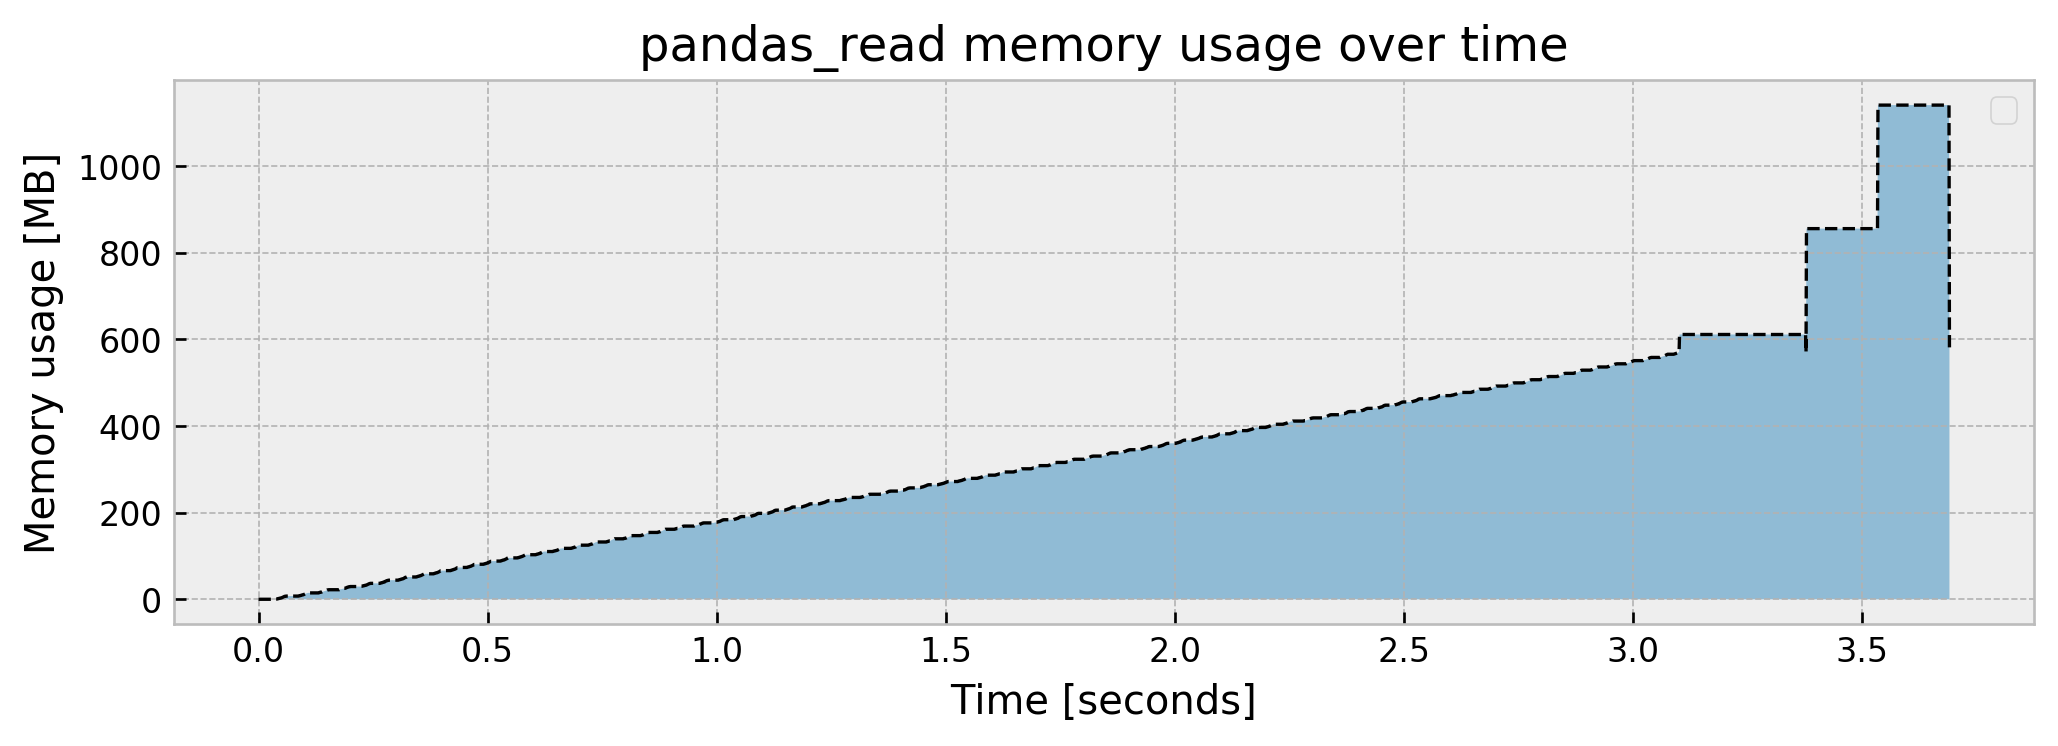

In [3]:
# importing
import pandas as pd

# using a function so we can track memory usage
@track_memory_use(close=False, return_history=True)
def pandas_read():
    
    # reading train data
    df_train = pd.read_csv('./train.csv')
    
    return df_train

# executing
df_train, mem_history_1 = pandas_read()

Memory slowly increases up until over 570 MB, then spikes to 1.14 GB and then drops to 570 MB again, which is the final size of the `df_train` object. The peak usage being double the final object size may suggest there is an inefficient copy somewhere in the `pd.read_csv` function, but I'll let this pass for now.

What should we do next? Train our model! Let us suppose that we've already done feature engineering, thus we only need to split our `train_data` into our design matrix `X_train` and target `y_train` and feed them to an `ExtraTreesClassifier`. Let us check how this step performs:

No handles with labels found to put in legend.


Current memory usage: 593.745988
Peak memory usage: 1916.650081


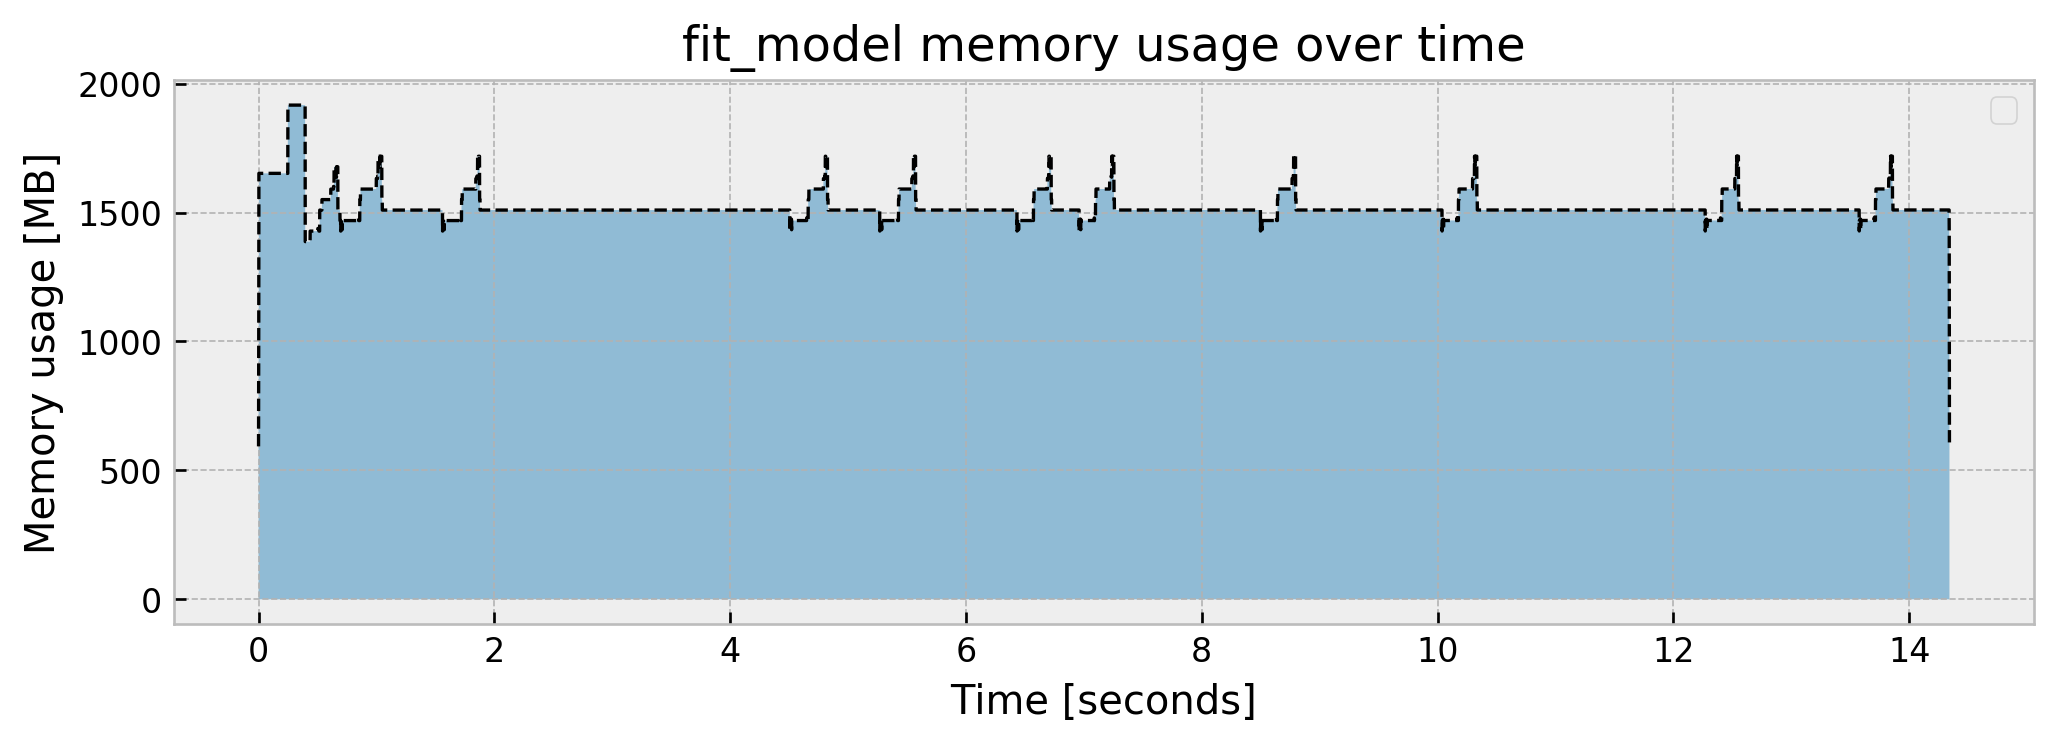

In [4]:
# importing model
from sklearn.ensemble import ExtraTreesClassifier

@track_memory_use(close=False, return_history=True)
def fit_model(train_data):
    
    # splitting
    X_train = train_data.drop('isFraud', axis=1)
    y_train = train_data['isFraud']
    
    # fitting model
    et = ExtraTreesClassifier(n_estimators=10, min_samples_leaf=10)
    et.fit(X_train, y_train)
    
    return et

model, mem_history_2 = fit_model(df_train)

We jump to a peak of 1.91 GB, and get a steady usage of around 1.5GB. There are little "spikes" throughout the fit, which I suspect are the fitting process of the individual trees (10 trees = 10 spikes). We end the process with 593 MB.

The final step in our pipeline is reading our test data, performing inference with our model, and reporting the test AUC:

No handles with labels found to put in legend.


Model result is: 0.9915

Current memory usage: 596.013196
Peak memory usage: 1069.332149


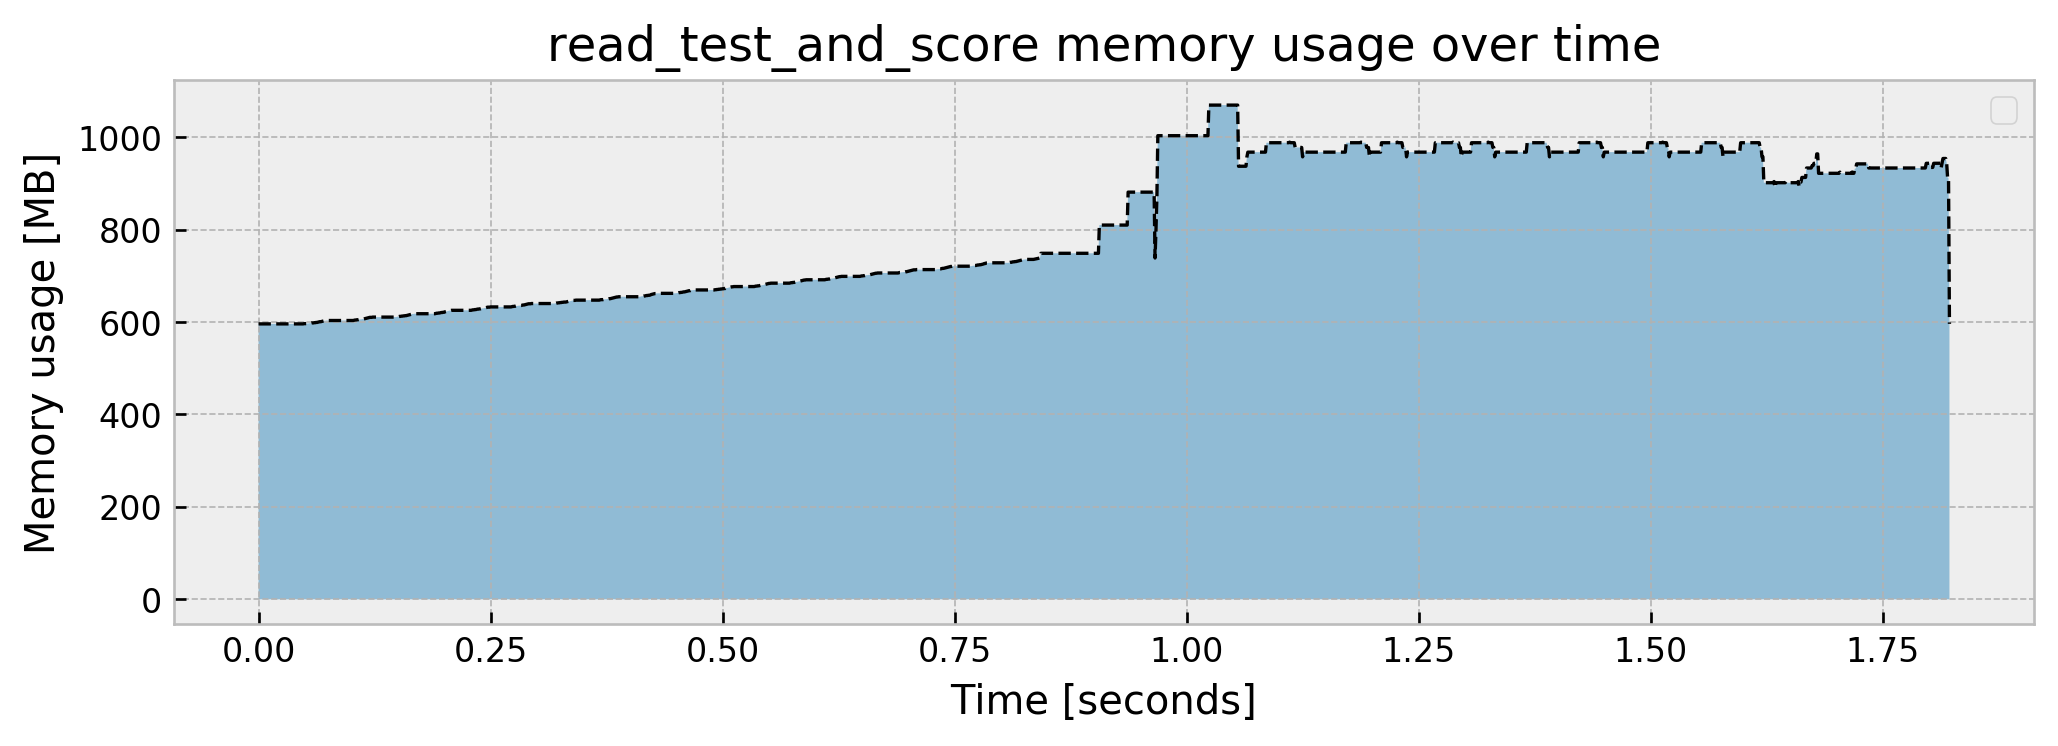

In [5]:
# importing metric
from sklearn.metrics import roc_auc_score

@track_memory_use(close=True, return_history=True)
def read_test_and_score(model):
    
    # reading test
    df_test = pd.read_csv('./test.csv')

    # splitting design matrix and target
    X_test = df_test.drop('isFraud', axis=1)
    y_test = df_test['isFraud']
    
    # scoring and printing result
    preds = model.predict_proba(X_test)
    score = roc_auc_score(y_test, preds[:,1])
    print(f'Model result is: {score:.4f}\n')
    
_, mem_history_3 = read_test_and_score(model)

We go from the previous step usage of around 600MB to a peak of 1.1GB and stop at around 600MB again. Also, our model's AUC is looking great, at `0.9915`. Putting it all together, our pipeline memory usage goes like this:

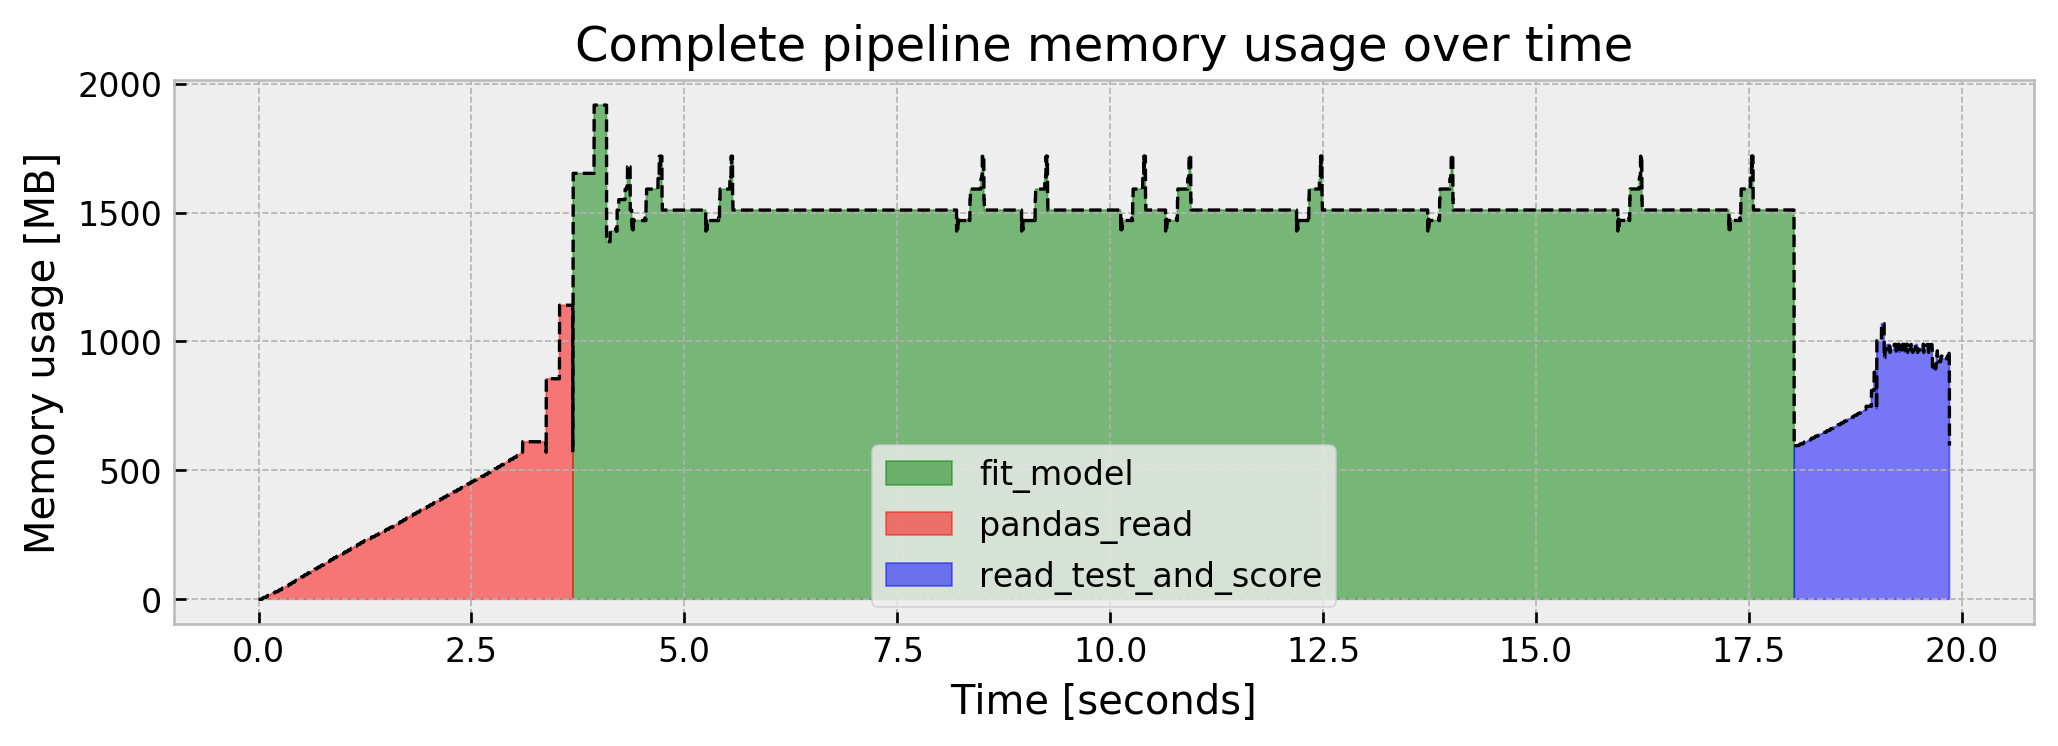

In [6]:
# putting memory usage together
total_mem_use = pd.concat([
    pd.DataFrame({'history': mem_history_1, 'step': 'pandas_read', 'color': 'red', 'offset':0}),
    pd.DataFrame({'history': mem_history_2, 'step': 'fit_model', 'color': 'green', 'offset':len(mem_history_1)}),
    pd.DataFrame({'history': mem_history_3, 'step': 'read_test_and_score', 'color': 'blue', 'offset':len(mem_history_1)+len(mem_history_2)})
])

# plotting
plt.figure(figsize=(10,3), dpi=120)
for step, group in total_mem_use.groupby('step'):
    plot_memory_use(history=group['history'].values, 
                    fn_name='Complete pipeline', 
                    open_figure=False, 
                    offset=group['offset'].unique(),
                    color=group['color'], 
                    label=step)

This is actually not much, but who knows, tomorrow we may be dealing with datasets and memory usages in the tens or hundreds of GBs. So, let us imagine that we're limited to less memory than we used in the naive case, for the sake of this post. The same tricks that we'll devise in this case should work for much larger datasets. 

So, what can we do?

## 0. Use Dask instead of pandas

A simple trick to constrain memory usage is replacing **pandas** for **dask**, since it is almost trivial (dask API is a subset of pandas, so it should work as drop-in replacement). Dask can do a lot more than I'll show here, scaling computation to thousands of machines in a cluster. For our purposes, however, we'll use it to constrain RAM usage, as it can distribute computation and use the disk for storing intermediate results.

Reading the dataframe using dask yields negligible RAM usage, while keeping the exact pandas syntax (just replace `pd` with `dd`):

In [7]:
import dask.dataframe as dd

# using a function so we can track memory usage
@track_memory_use(plot=False)
def dask_read(blocksize):
    
    # reading train data
    df_train = dd.read_csv('./train.csv')

    return dd.read_csv('./train.csv', blocksize=blocksize)

# executing
df_dd = dask_read(blocksize=50e6)

Current memory usage: 1.541610
Peak memory usage: 1.897767


That's because dask did not actually read the entire dataset. When we call `dd.read_csv` we perform two things:

1. Scan the dataframe columns and infer dtypes
2. Split the dataset into partitions with size `blocksize` and build the computational graph to process these partitions independently

For instance, when we check the object `df_dd`, it just gives us our dataframe's structure:

In [8]:
df_dd

Dask DataFrame Structure:
                step   amount oldBalanceOrig newBalanceOrig oldBalanceDest newBalanceDest isFraud type_CASH_IN type_CASH_OUT type_DEBIT type_PAYMENT type_TRANSFER errorBalanceOrig errorBalanceDest
npartitions=8                                                                                                                                                                                       
               int64  float64        float64        float64        float64        float64   int64        int64         int64      int64        int64         int64          float64          float64
                 ...      ...            ...            ...            ...            ...     ...          ...           ...        ...          ...           ...              ...              ...
...              ...      ...            ...            ...            ...            ...     ...          ...           ...        ...          ...           ...              ...              ...
                 ...      ...            ...            ...            ...            ...     ...          ...           ...        ...          ...           ...              ...              ...
                 ...      ...            ...            ...            ...            ...     ...          ...           ...        ...          ...           ...              ...              ...
Dask Name: from-delayed, 24 tasks

As for the computational graph, we can visualize it by using the `.visualize()` method:

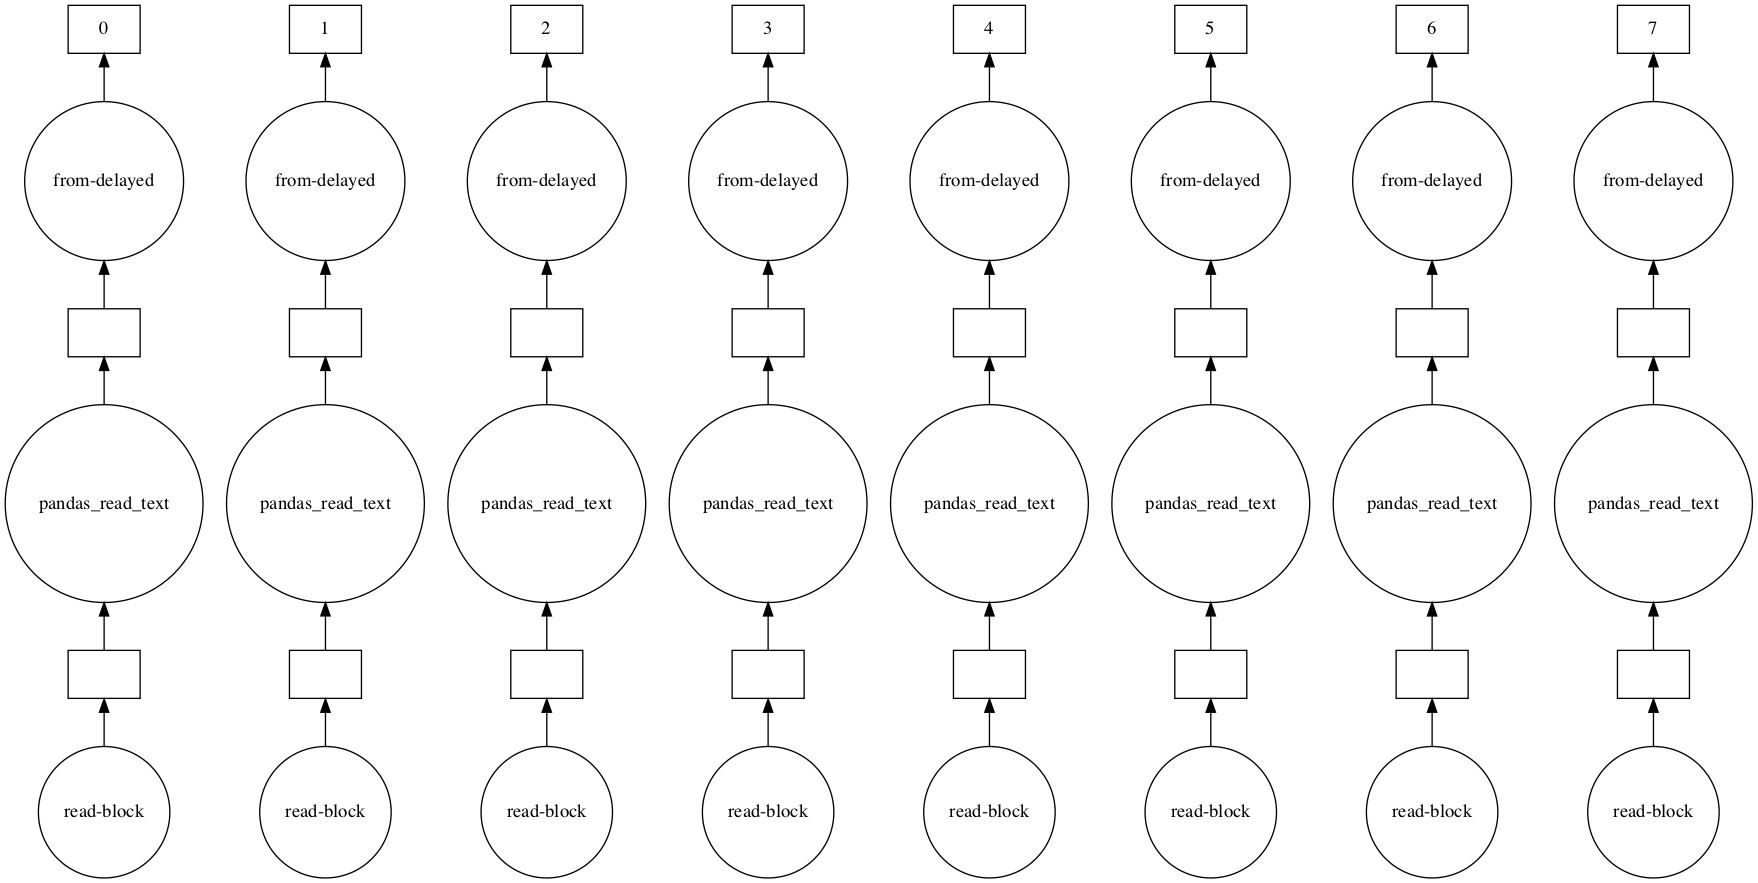

In [9]:
df_dd.visualize()

This graph tells us that dask will independently process eight partitions of our dataframe when we actually do perform computations. This is how distributed computation works: you break your work into smaller, independent pieces and run them in parallel.

But how do we compute stuff using dask? We use the `.compute()` method. Let us try it for checking how unbalanced our target variable `isFraud` is, by getting the prevalence of `1`'s in it. 

For a fair comparison to pandas, we will track memory usage all the way from reading the data, and will set `scheduler='synchronous'` in the `.compute()` method, so we run single-threaded.

Let us start with pandas. We read the dataframe, calculate the fraction of frauds in the dataset, store it in the variable `fraud_prevalence`, and finally print the value:

No handles with labels found to put in legend.


Fraud prevalence is: 0.128%

Current memory usage: 0.159460
Peak memory usage: 1140.358535


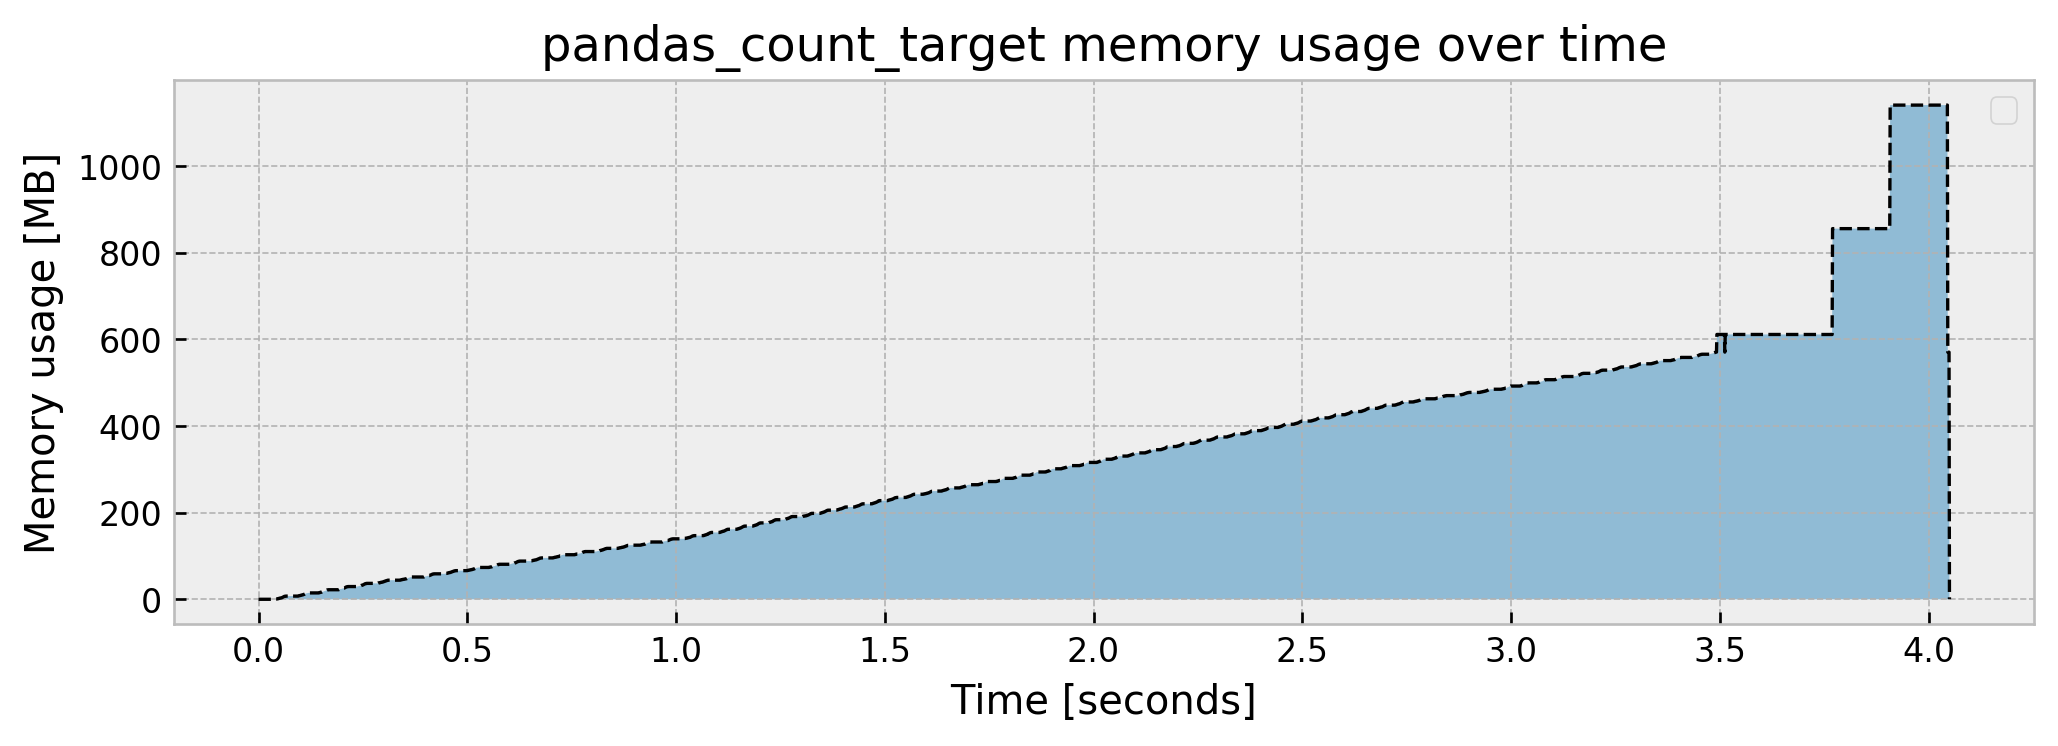

In [10]:
@track_memory_use()
def pandas_count_target():
    df = pd.read_csv('./train.csv')
    fraud_prevalence = (df['isFraud'].sum()/df['isFraud'].shape[0])
    print(f'Fraud prevalence is: {fraud_prevalence*100:.3f}%\n')

pandas_count_target()

As calculating `fraud_prevalence` is fairly simple, the memory usage is almost the same as reading the dataframe, apart from the fact that we don't return it and thus get a very low memory footprint when we step out of the function.

Let us now use dask. The syntax is exactly the same, apart from the `.compute(scheduler='synchronous')` method, which instructs dask to not only build the graph, but actually perform computations.

No handles with labels found to put in legend.


Fraud prevalence is: 0.128%

Current memory usage: 26.522038
Peak memory usage: 249.080990


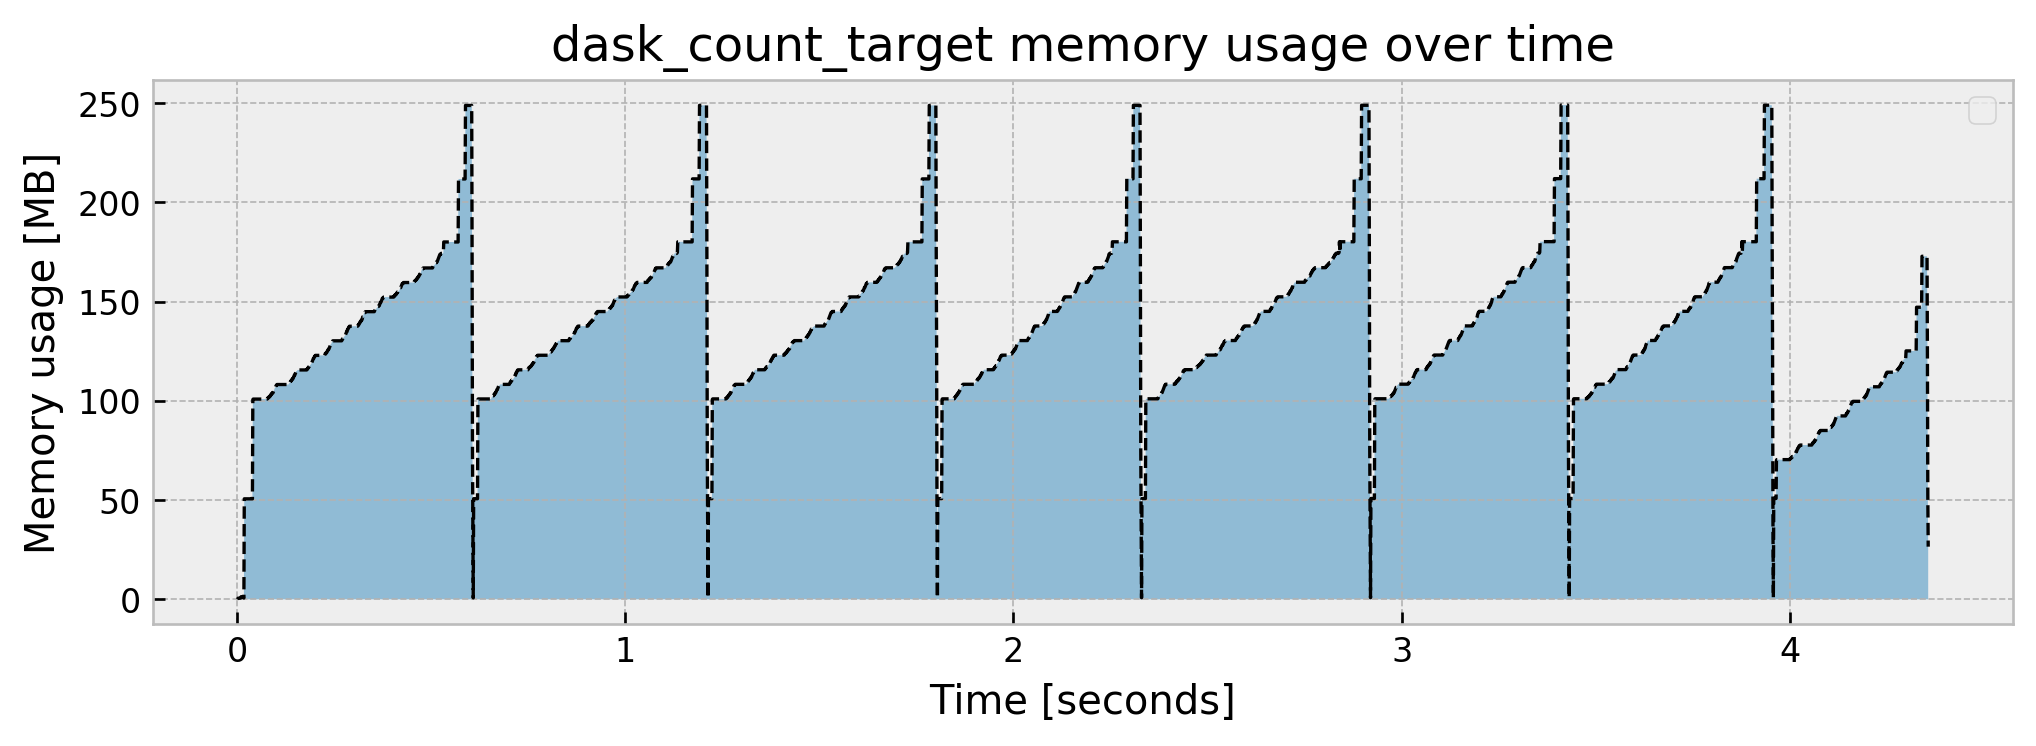

In [11]:
@track_memory_use()
def dask_count_target(blocksize):
    df = dd.read_csv('./train.csv', blocksize=blocksize)
    fraud_prevalence = (df['isFraud'].sum()/df['isFraud'].shape[0]).compute(scheduler='synchronous')
    print(f'Fraud prevalence is: {fraud_prevalence*100:.3f}%\n')

dask_count_target(blocksize=50e6)

We get this interesting plot. It takes a little bit more time but memory usage is much lower at around a 250 MB peak. Remember the computational graph, broke into eight partitions? As we used a single thread (`scheduler='synchronous'`) dask performed the computation sequentially, and as we can see in the graph, there are eight "blocks" through time. If we don't use the `'scheduler='synchronous'` parameter, dask will distribute computation across cores and threads:

No handles with labels found to put in legend.


Fraud prevalence is: 0.128%

Current memory usage: 0.845965
Peak memory usage: 1453.167118


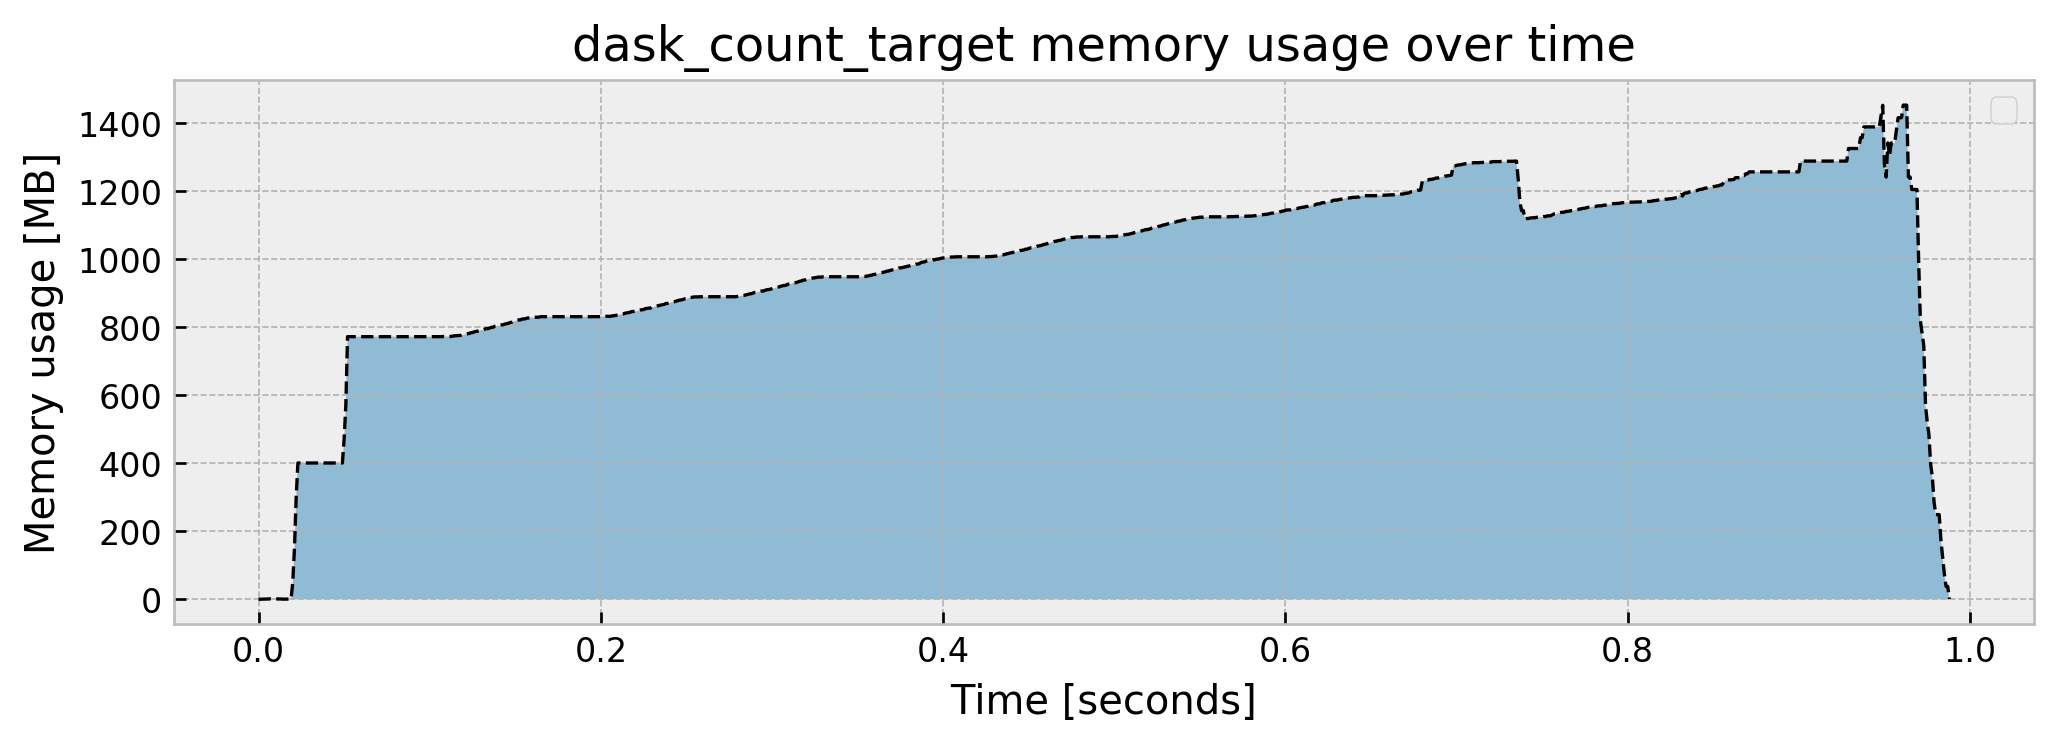

In [12]:
@track_memory_use()
def dask_count_target(blocksize):
    df = dd.read_csv('./train.csv', blocksize=blocksize)
    fraud_prevalence = (df['isFraud'].sum()/df['isFraud'].shape[0]).compute()
    print(f'Fraud prevalence is: {fraud_prevalence*100:.3f}%\n')

dask_count_target(blocksize=50e6)

It uses even more memory than pandas (not a lot more, though), but it gets to the result much faster (approximately 1s vs. 4s).

Our simple operation yields a very cool computational graph, shown in the figure below. For clarity, I now use `blocksize=100e6` which splits the dataset into 4 partitions. For each partition, dask calculates a `sum-chunk` and a `size-chunk` which are the sum of the `isFraud` variable for the partition and the number of rows of the partition, respectively. Then, dask aggregates the `sum-chunks` and the `size-chunks` together into `sum-agg` and `size-agg`. Finally, dask divides these values to get the prevalence. Even though we depend on scanning all the data to get our result, much of the work can be done in parallel, and dask cleverly makes use of the parallelism and abstracts the details away from us.

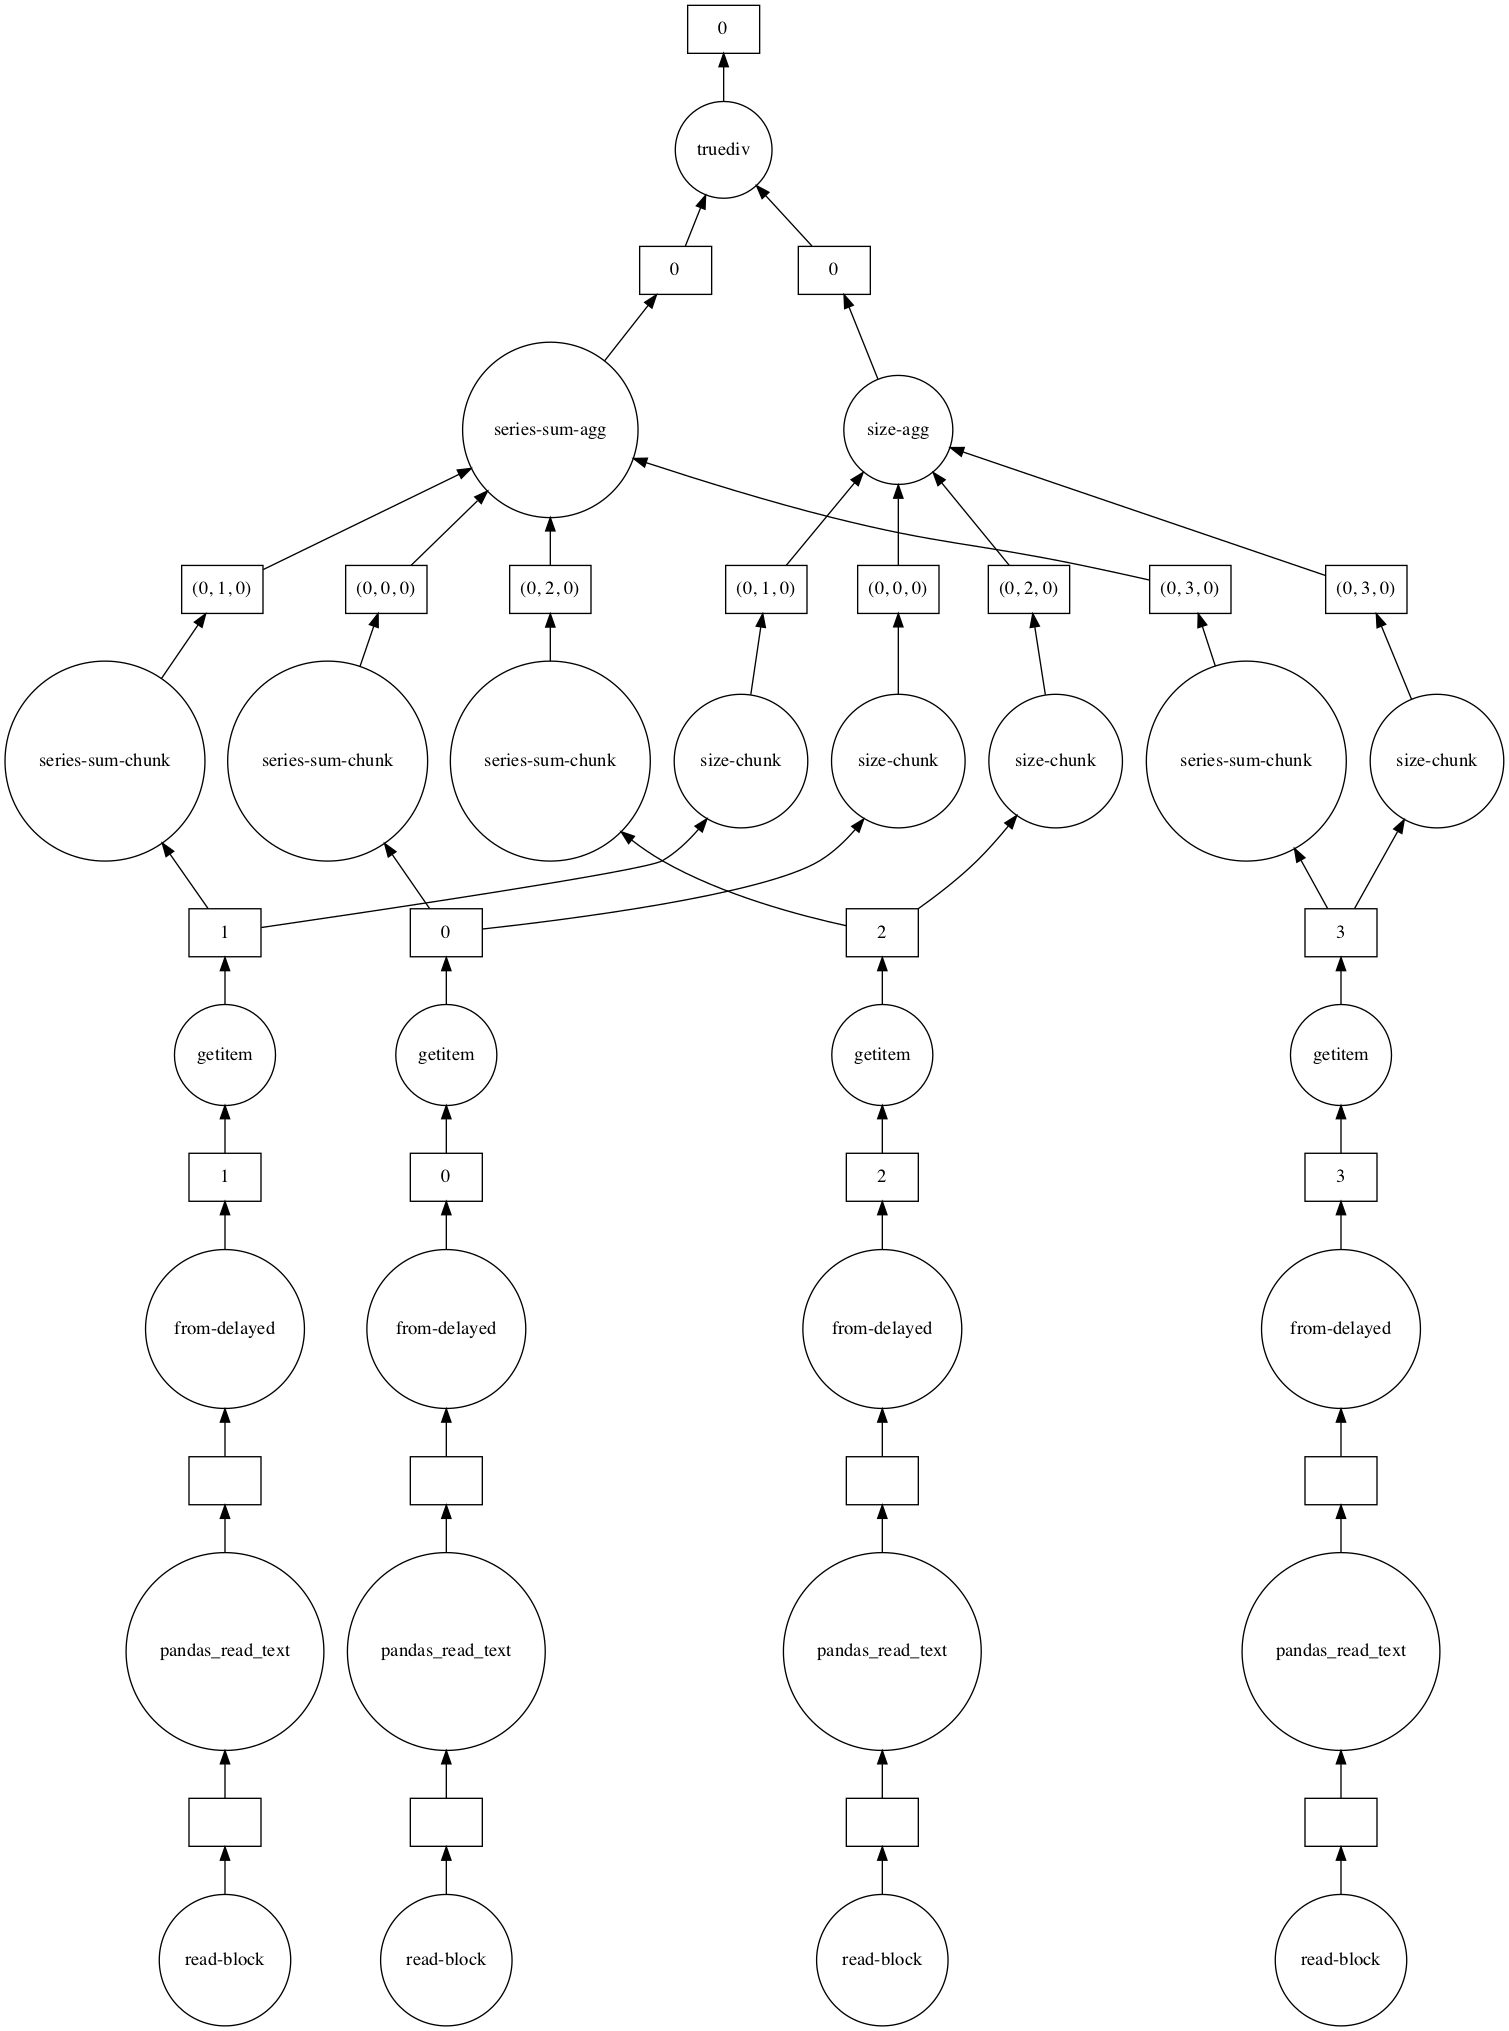

In [13]:
# let us check the computational graph
df = dd.read_csv('./train.csv', blocksize=100e6)
fraud_prevalence = (df['isFraud'].sum()/df['isFraud'].shape[0])
graph = fraud_prevalence.visualize()
graph

Going back to the sequential scheduler, if we want to further reduce peak memory usage, we can just reduce `blocksize`:

No handles with labels found to put in legend.


Fraud prevalence is: 0.128%

Current memory usage: 4.690656
Peak memory usage: 50.915560


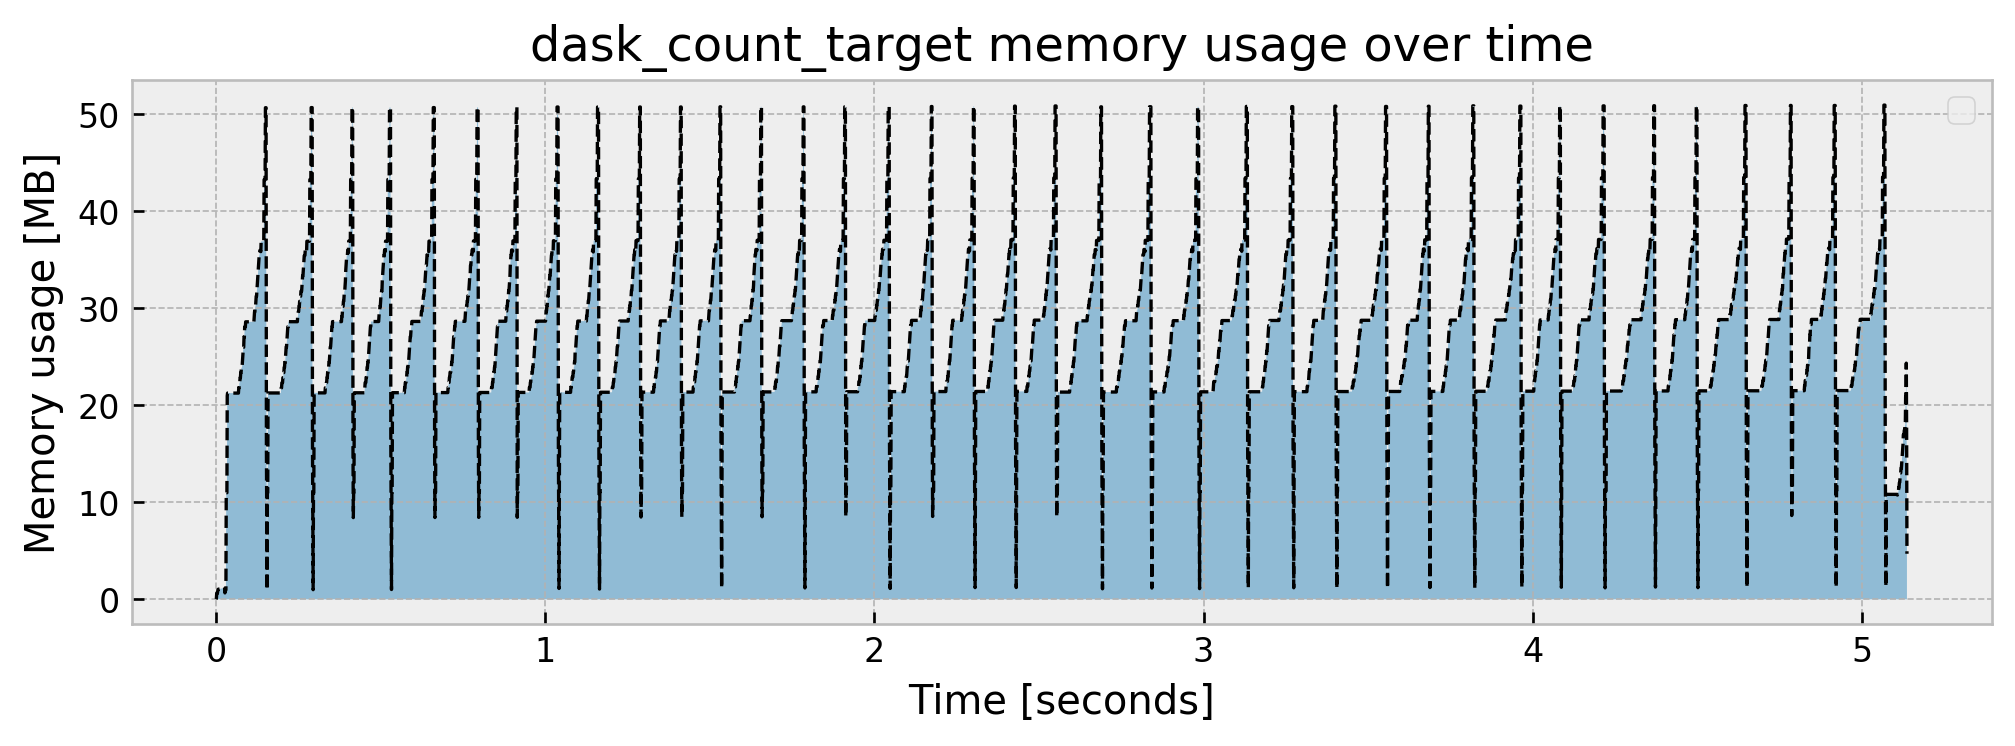

In [14]:
@track_memory_use()
def dask_count_target(blocksize):
    df = dd.read_csv('./train.csv', blocksize=blocksize)
    fraud_prevalence = (df['isFraud'].sum()/df['isFraud'].shape[0]).compute(scheduler='synchronous')
    print(f'Fraud prevalence is: {fraud_prevalence*100:.3f}%\n')

dask_count_target(blocksize=10e6)

This further reduces peak memory consumption to 50MB, with the tradeoff that the operation takes 1 second longer as compared to pandas.

Cool! By using dask, we can (almost) still perform computations as we would do in pandas, but with a fairly reduced memory footprint. But our goal is not moving data around, but rather fitting models and solving our fraud analytics problem. Let us then use dask as a platform to improve our whole pipeline, along with some other tricks.

### 1. Train with a sample

Train with a sample? Yeah, I know...

When you're a data scientist, it's very hard not to use all the data: it is sitting there, waiting to be analyzed! But, using a sample of your data is actually a very simple and effective way to reduce memory overhead when training models. Remember that we're using statistical learning: if the number of samples is large enough, adding more data to your model has diminishing returns. So let us test doing this simple trick first!

But we still have to scan the whole dataset to extract a sample of it! That's why we have dask! Let us rewrite the `pandas_read` function to a `dask_read_and_sample` function that reads and samples the data with dask:

No handles with labels found to put in legend.


Current memory usage: 31.991831
Peak memory usage: 81.060181


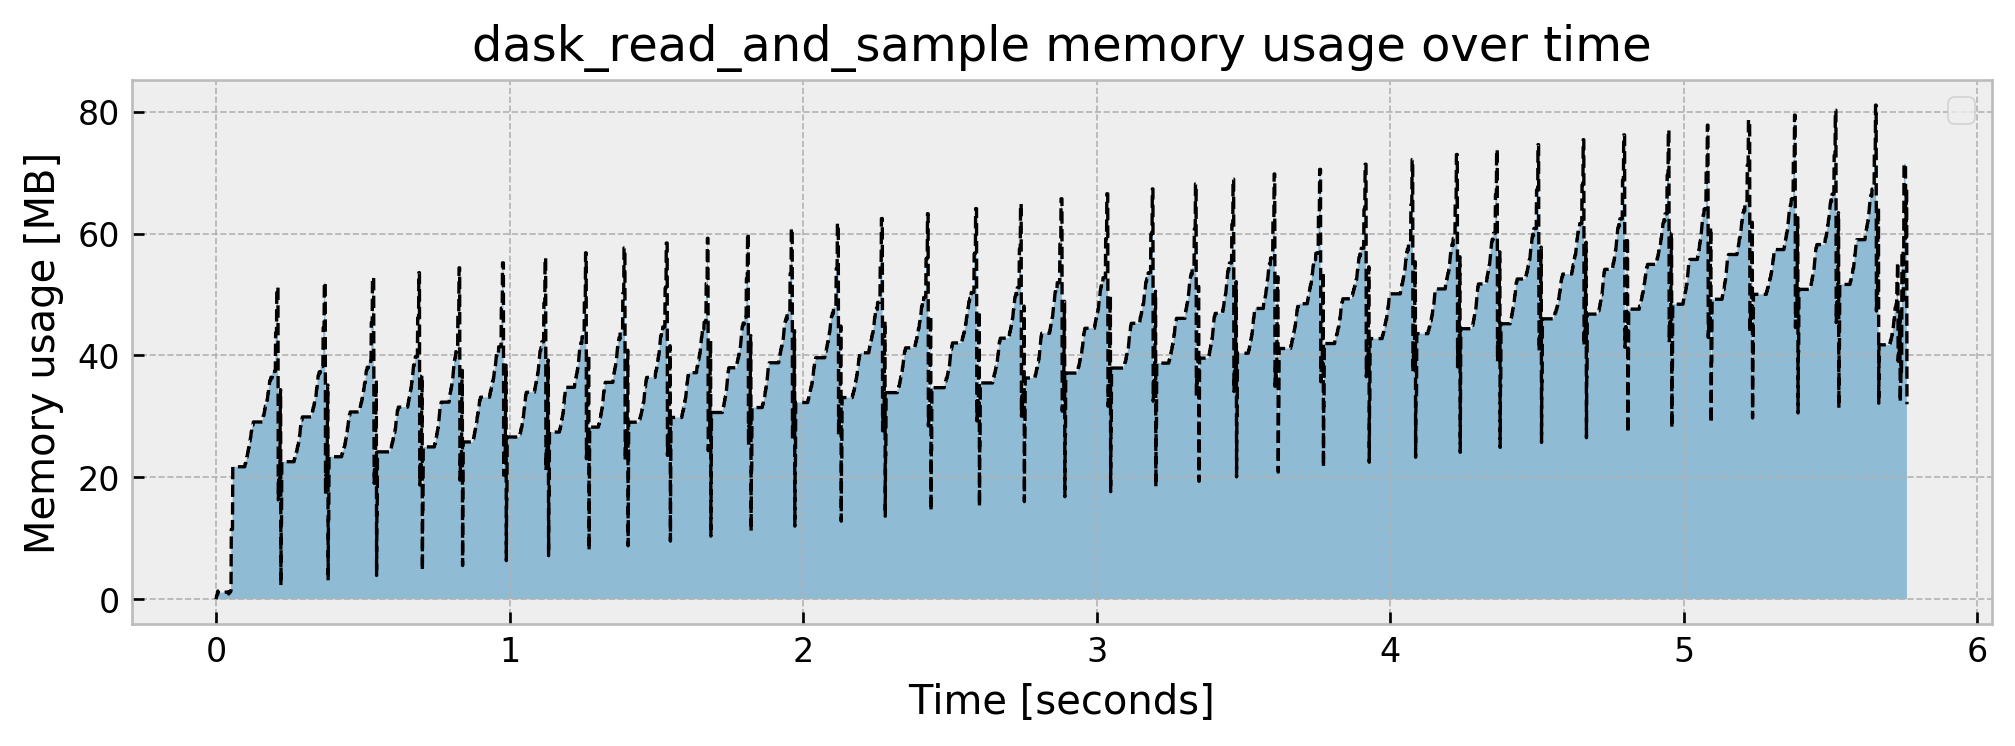

In [15]:
# using a function so we can track memory usage
@track_memory_use(close=False, return_history=True)
def dask_read_and_sample(blocksize, sample_size):
    
    # reading train data
    df_train = dd.read_csv('./train.csv', blocksize=blocksize)
    
    # let us stratify to get the same number of rows for frauds and non-frauds
    sample_positive = df_train.query('isFraud == 1').sample(frac=sample_size)
    sample_negative = df_train.query('isFraud == 0').sample(frac=sample_size)
    
    # concatenate the dataframe
    df_sampled = dd.concat([sample_positive, sample_negative])
    
    return df_sampled.compute(scheduler='synchronous')

# executing
df_train, mem_history_1 = dask_read_and_sample(blocksize=10e6, sample_size=0.05)

Cool. We've got a great memory reduction with a peak rate of 81 MB and final usage of 32 MB, as expected, as we took a 5% sample of our dataset. Let us check how the rest of the pipeline fares:

No handles with labels found to put in legend.


Current memory usage: 78.268949
Peak memory usage: 98.597381


No handles with labels found to put in legend.


Model result is: 0.9768

Current memory usage: 32.833247
Peak memory usage: 506.189869


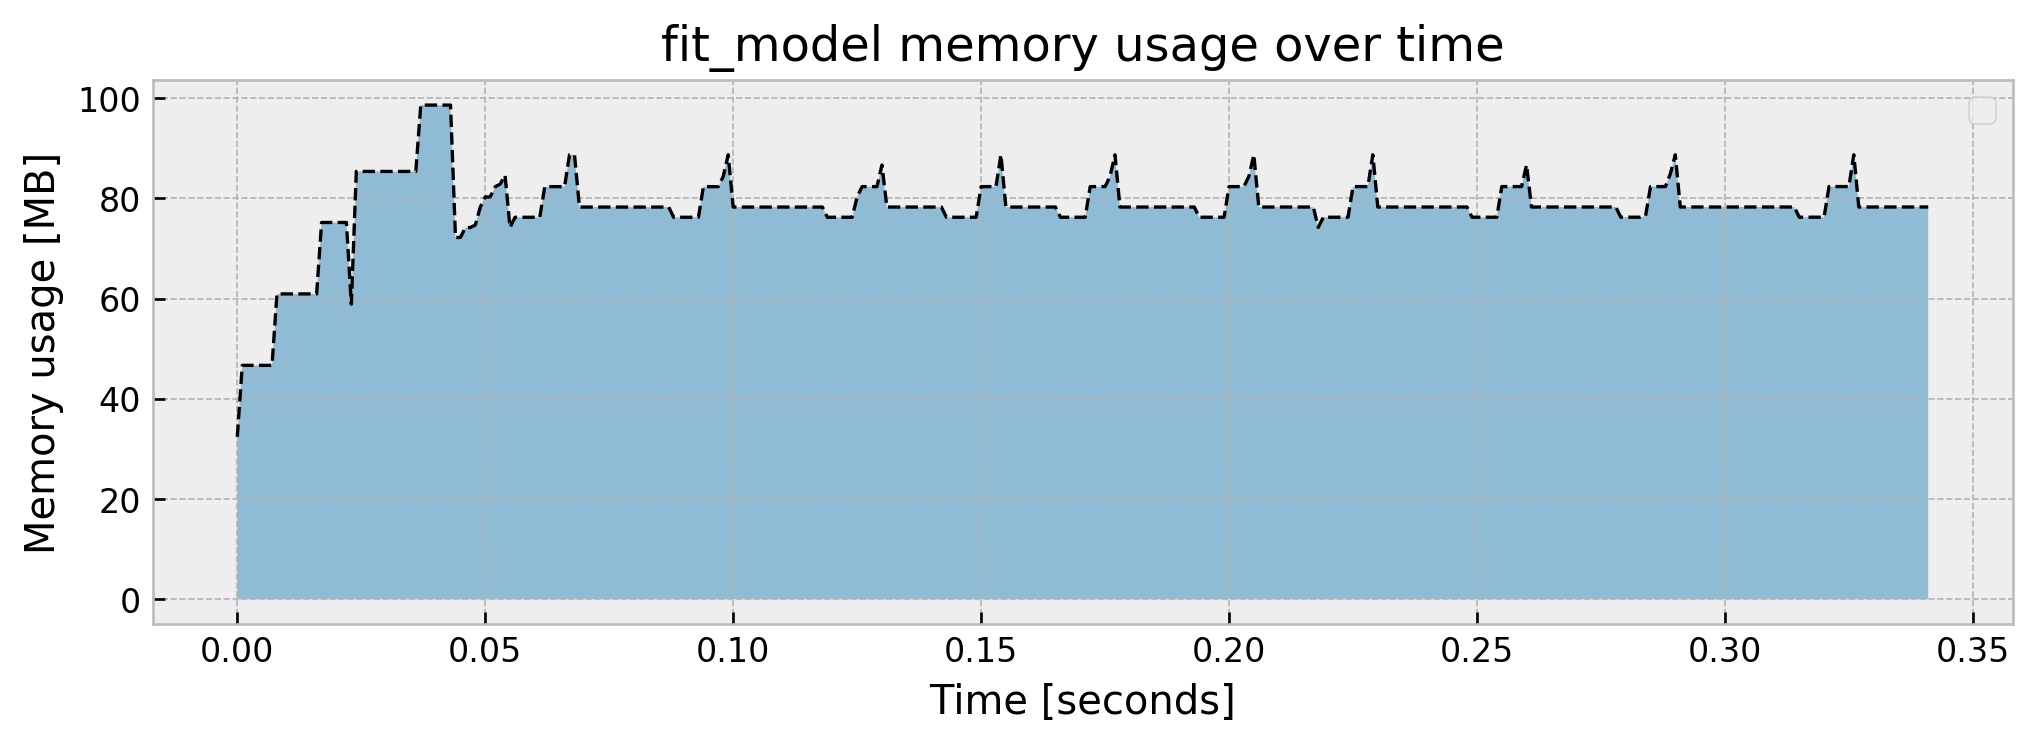

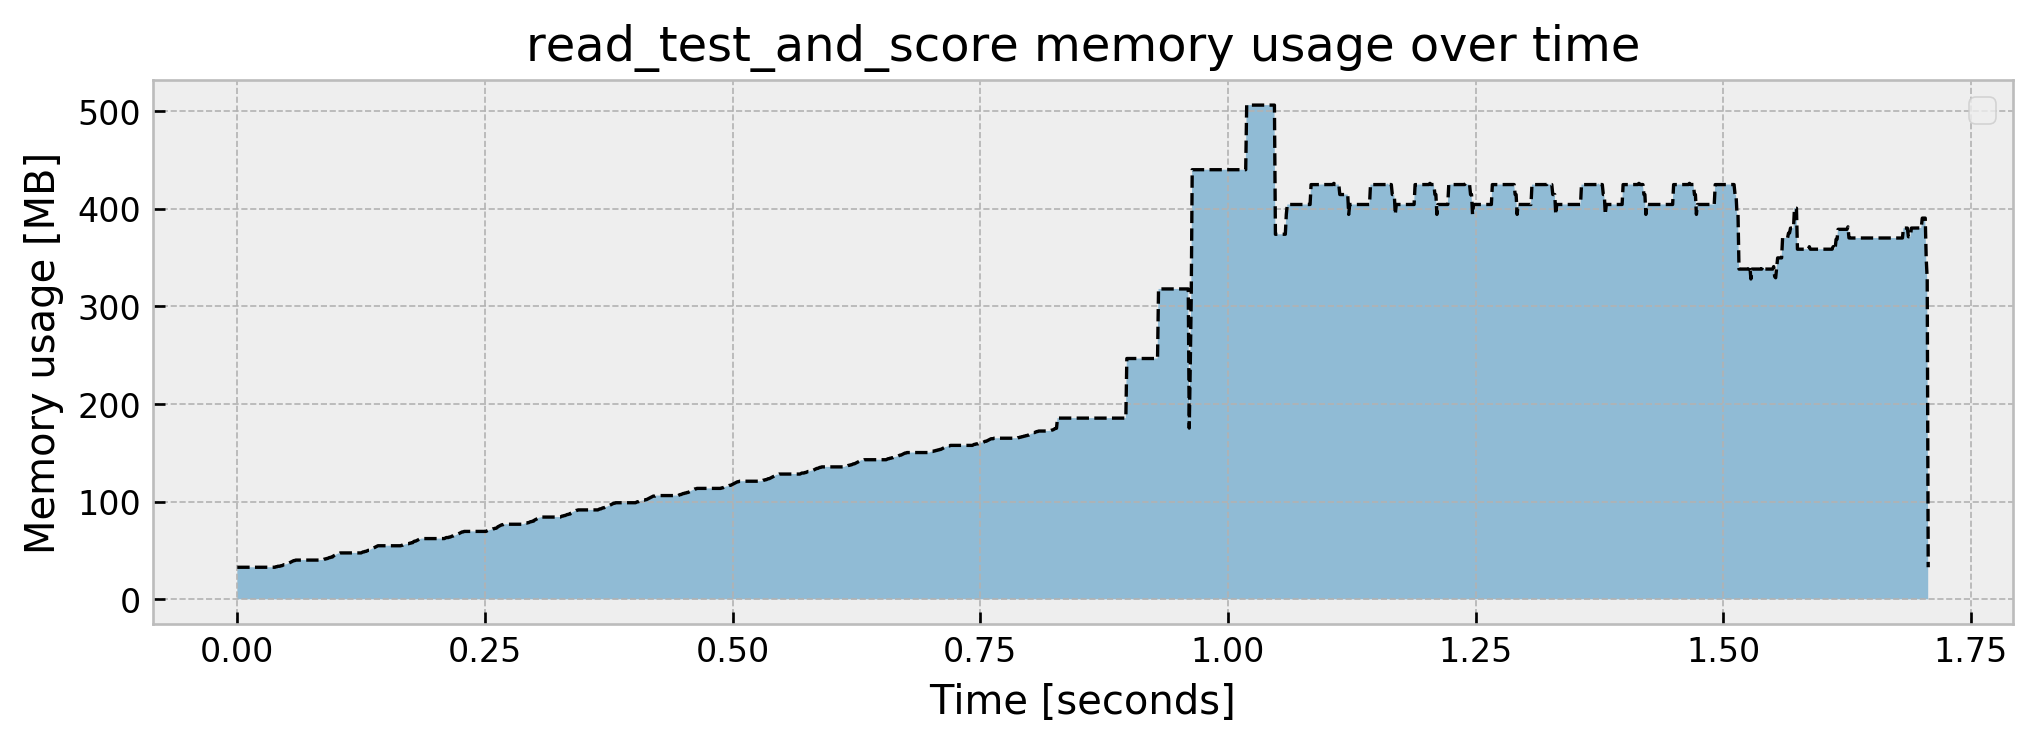

In [16]:
@track_memory_use(close=False, return_history=True)
def read_test_and_score(model):
    
    # reading test
    df_test = pd.read_csv('./test.csv')

    # splitting design matrix and target
    X_test = df_test.drop('isFraud', axis=1)
    y_test = df_test['isFraud']
    
    # scoring and printing result
    preds = model.predict_proba(X_test)
    score = roc_auc_score(y_test, preds[:,1])
    print(f'Model result is: {score:.4f}\n')


model, mem_history_2 = fit_model(df_train)
_, mem_history_3 = read_test_and_score(model)

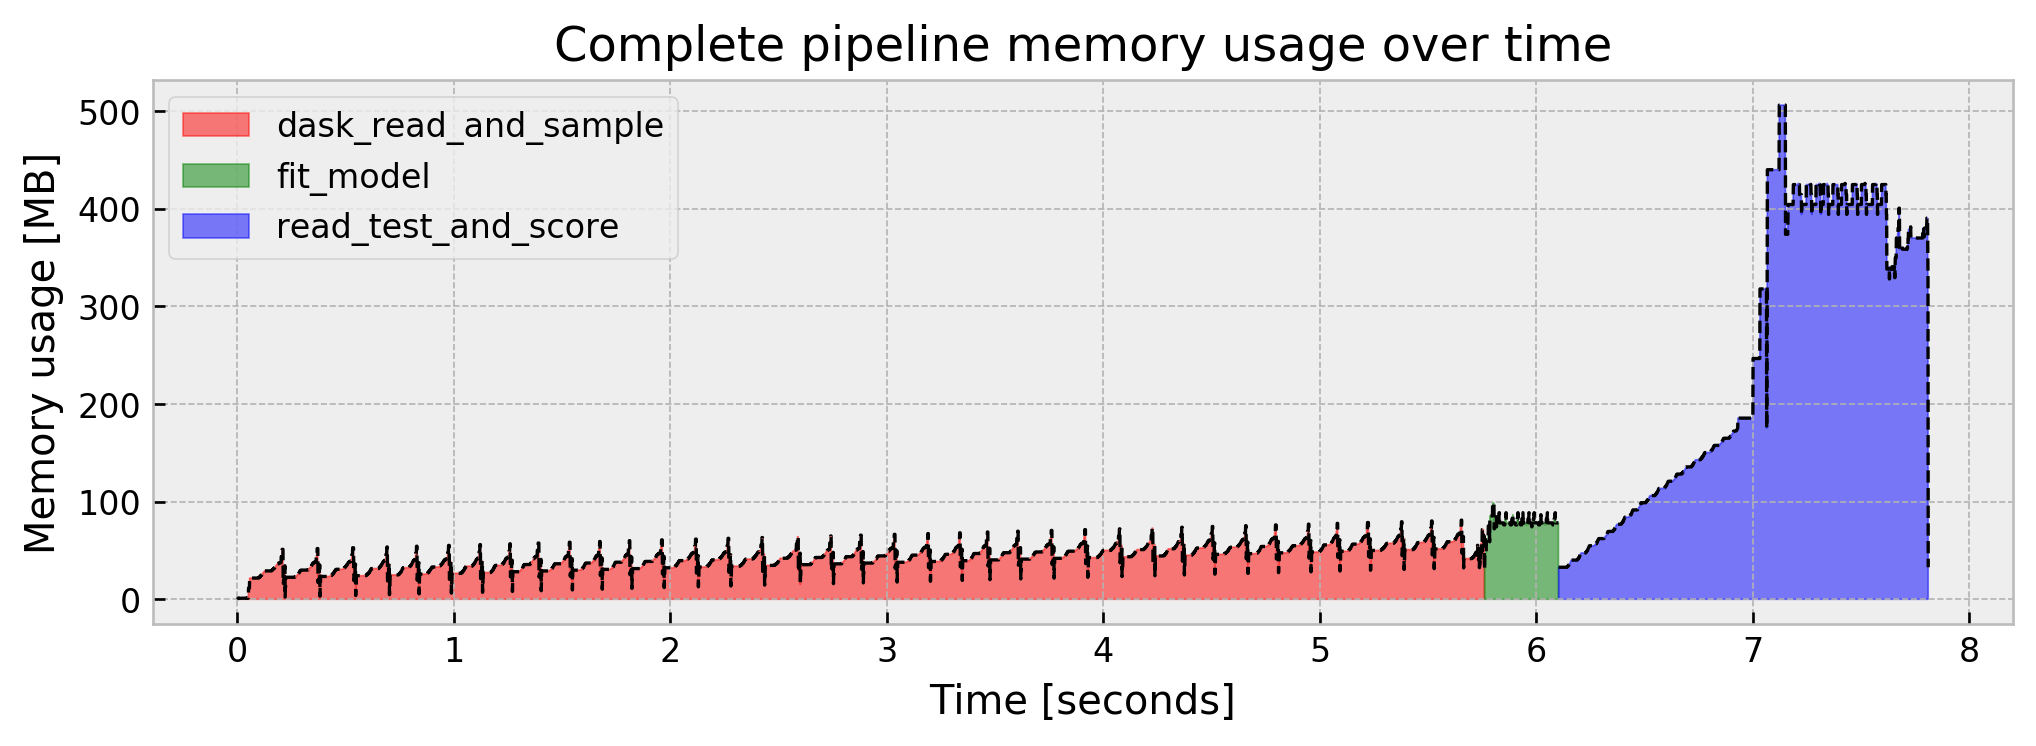

In [17]:
# putting memory usage together
total_mem_use_2 = pd.concat([
    pd.DataFrame({'history': mem_history_1, 'step': 'dask_read_and_sample', 'color': 'red', 'offset':0}),
    pd.DataFrame({'history': mem_history_2, 'step': 'fit_model', 'color': 'green', 'offset':len(mem_history_1)}),
    pd.DataFrame({'history': mem_history_3, 'step': 'read_test_and_score', 'color': 'blue', 'offset':len(mem_history_1)+len(mem_history_2)})
])

# plotting
plt.figure(figsize=(10,3), dpi=120)
for step, group in total_mem_use_2.groupby('step'):
    plot_memory_use(history=group['history'].values, 
                    fn_name='Complete pipeline', 
                    open_figure=False, 
                    offset=group['offset'].unique(),
                    color=group['color'], 
                    label=step)

Cool! We went from a 1.91 GB peak to a 536 MB peak. But there's some things we now can improve further:

1. Our memory bottleneck now is the scoring part of the pipeline
2. Our AUC dropped from `0.9915` to `0.9768`. This may be acceptable, but it's kinda hard to let it go...
 
Let us improve our tricks!

## 2. Perform inference in blocks

Now our bottleneck is model inference. As the test dataset is 4x smaller than the train dataset, I did not bother to use dask instead of pandas in the scoring part of the pipeline. Let us change that, and make our model perform inference block by block:

No handles with labels found to put in legend.


Model result is: 0.9768

Current memory usage: 180.249329
Peak memory usage: 242.521037


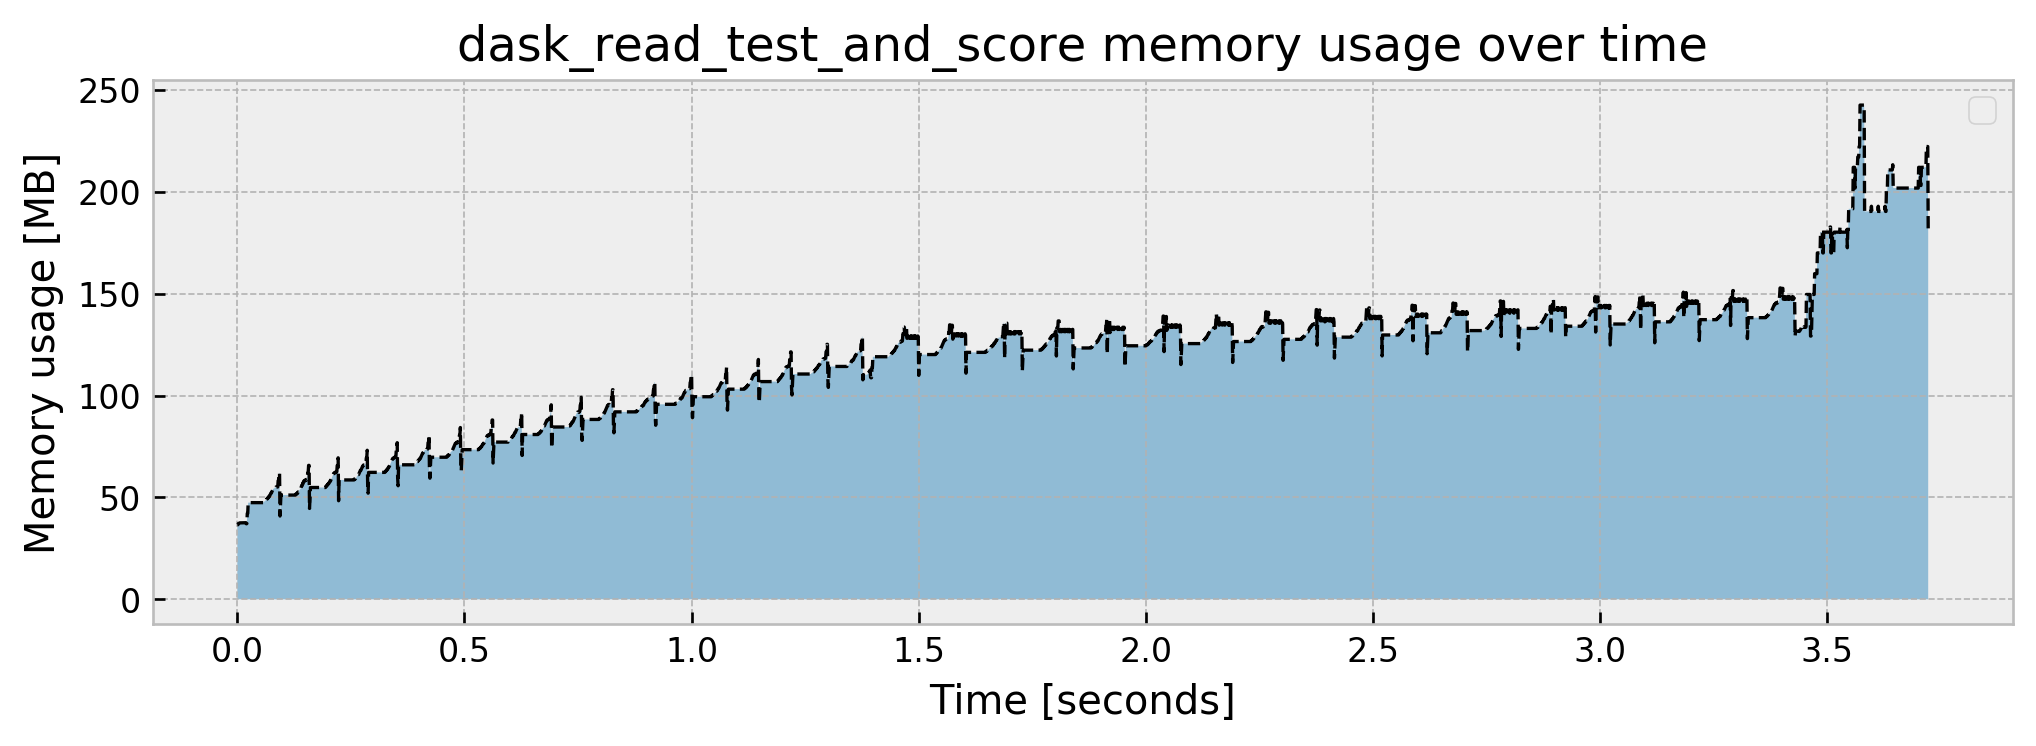

In [18]:
@track_memory_use(close=True, return_history=True)
def dask_read_test_and_score(model, blocksize):
    
    # reading test
    df_test = dd.read_csv('./test.csv', blocksize=blocksize)

    # splitting design matrix and target
    X_test = df_test.drop('isFraud', axis=1)
    y_test = df_test['isFraud'].persist(scheduler='synchronous')
    
    # scoring and printing result
    preds = X_test.map_partitions(model.predict_proba).compute(scheduler='synchronous')
    score = roc_auc_score(y_test, preds[:,1])
    print(f'Model result is: {score:.4f}\n')
    
_, mem_history_3 = dask_read_test_and_score(model, blocksize=5e6)

The implementation is fairly easy. Just use `dd.read_csv` and set a block size, divide the data into `X_test` and `y_test`, and use `X_test.map_partitions(model.predict_proba)` and `.compute(scheduler='synchronous')` which will apply our trained model to each partition and get predictions sequentially. As AUC is hard to distribute, I made the choice to bring `y_test` to memory via the `.persist()` method and calculate the AUC in-memory as well, but this may be improved after some thought. 

Let us check the complete pipeline results:

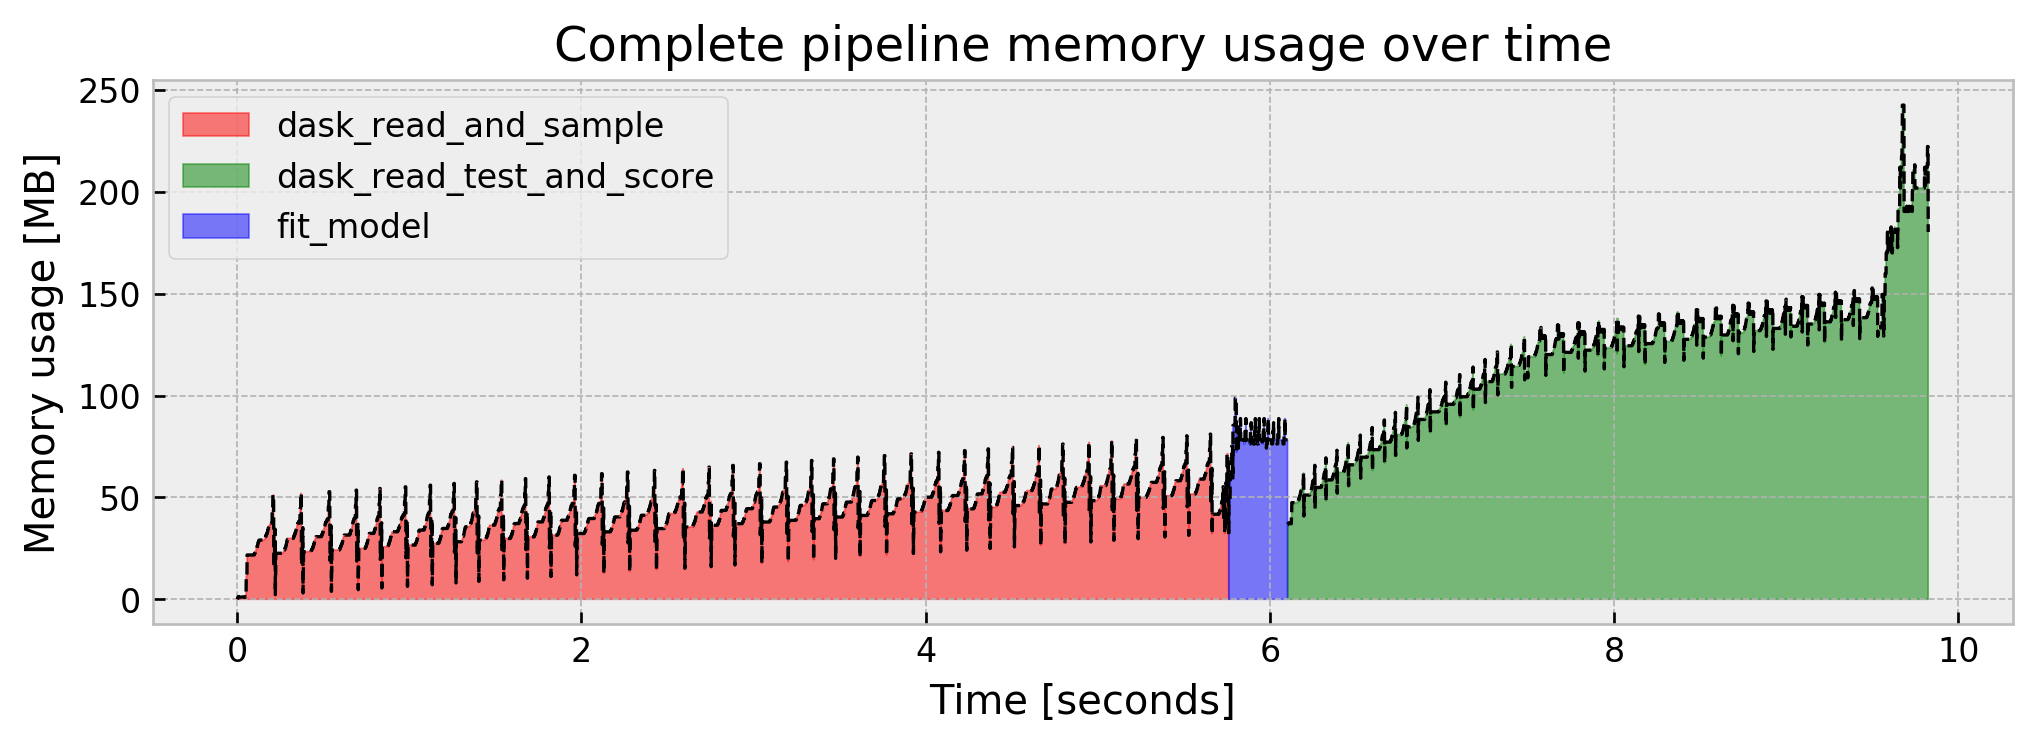

In [19]:
# putting memory usage together
total_mem_use_4 = pd.concat([
    pd.DataFrame({'history': mem_history_1, 'step': 'dask_read_and_sample', 'color': 'red', 'offset':0}),
    pd.DataFrame({'history': mem_history_2, 'step': 'fit_model', 'color': 'blue', 'offset':len(mem_history_1)}),
    pd.DataFrame({'history': mem_history_3, 'step': 'dask_read_test_and_score', 'color': 'green', 'offset':len(mem_history_1) + len(mem_history_2)}),
])

# plotting
plt.figure(figsize=(10,3), dpi=120)
for step, group in total_mem_use_4.groupby('step'):
    plot_memory_use(history=group['history'].values, 
                    fn_name='Complete pipeline', 
                    open_figure=False, 
                    offset=group['offset'].unique(),
                    color=group['color'], 
                    label=step)

Much better!!! We've reduced peak memory usage by a factor of almost 10x in comparison to the naive model. But it was at the cost of model performance. Can we improve AUC without sacrificing memory usage?

## 3. *Train with a sample*, but on steroids: Bagging

What if training with a sample was the same as training with the full dataset? Instead of producing just a single model, we can run `dask_read_and_sample` and `fit_model` multiple times and combine the models produced in an ensemble. This is akin to Bagging, but with a reduced sample! It will take a lot more time, but it will allow us to stay low on memory and maybe improve our AUC. 

We fit 10 models, each on a different 5% sample of the dataset, with replacement:

No handles with labels found to put in legend.


Current memory usage: 2.437998
Peak memory usage: 113.415603


No handles with labels found to put in legend.


Model result is: 0.9932

Current memory usage: 157.656477
Peak memory usage: 216.875133


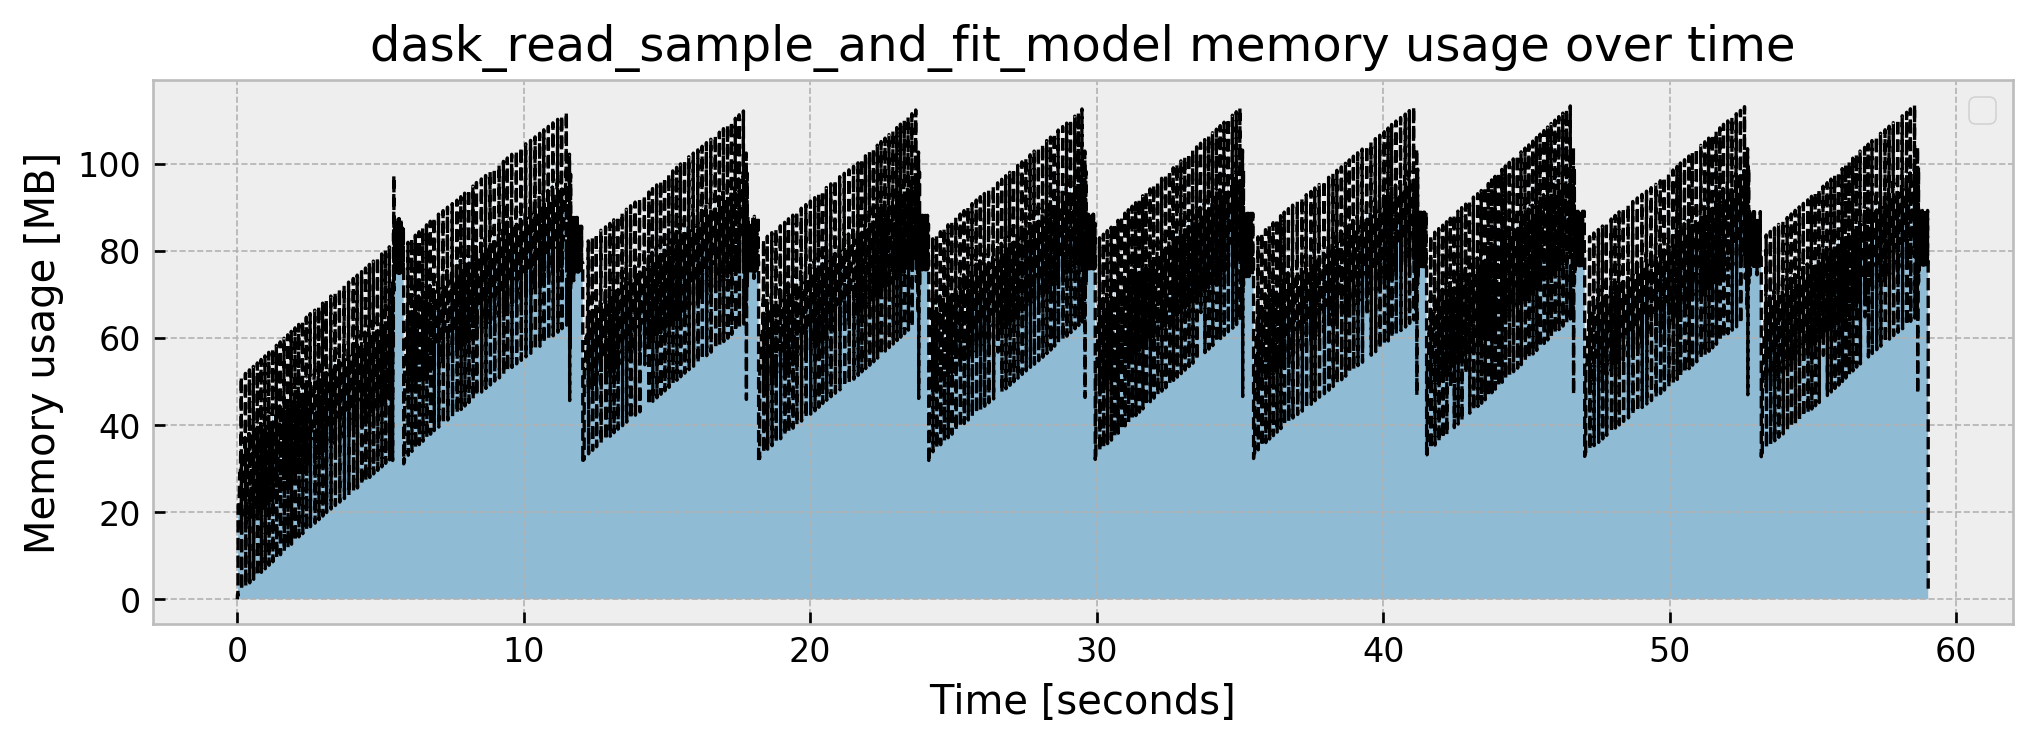

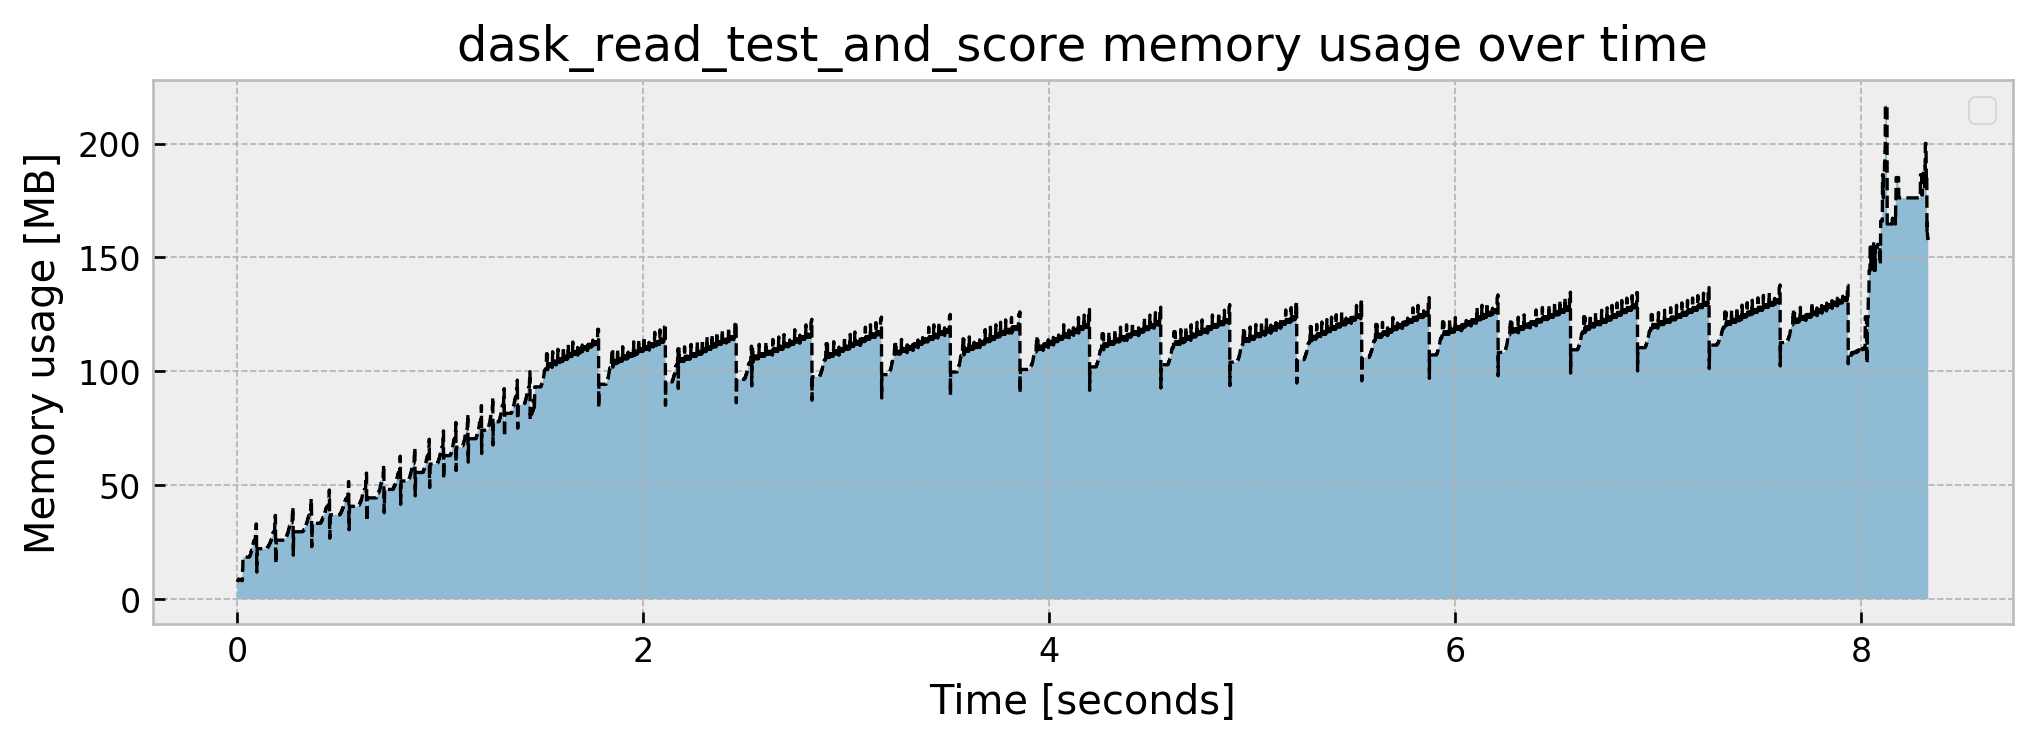

In [20]:
class EnsembleWrapper:
    
    """
    Wrapper for our ensemble.
    """
    
    def __init__(self, model_list):
        self.model_list = model_list
    def predict_proba(self, X):
        preds_list = [e.predict_proba(X) for e in self.model_list]
        return np.array(preds_list).mean(axis=0)


# using a function so we can track memory usage
@track_memory_use(close=False, return_history=True)
def dask_read_sample_and_fit_model(blocksize, sample_size, n_models):
    
    # list of models
    model_list = []
    
    # loop for each model
    for _ in range(n_models):
    
        # reading train data
        df_train = dask_read_and_sample.__wrapped__(blocksize=10e6, sample_size=sample_size)

        # fitting model
        model_list.append(fit_model.__wrapped__(df_train))
    
    return EnsembleWrapper(model_list)
    
# executing
model, mem_history_1 = dask_read_sample_and_fit_model(blocksize=10e6, sample_size=0.05, n_models=10)
_, mem_history_2 = dask_read_test_and_score(model, blocksize=5e6)

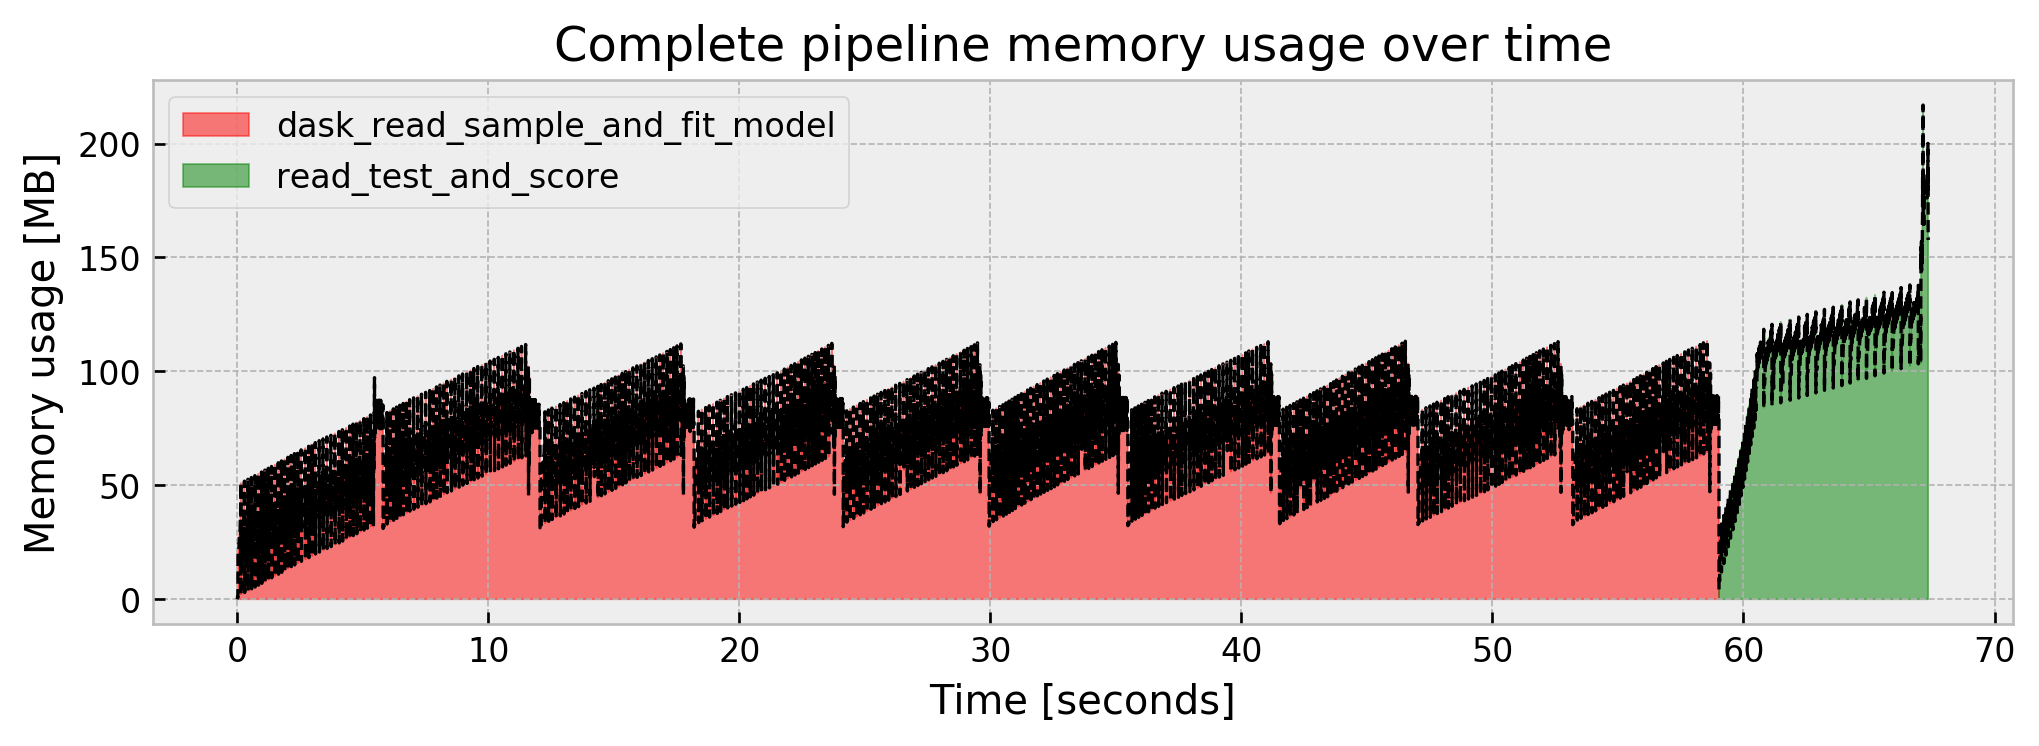

In [21]:
# putting memory usage together
total_mem_use_3 = pd.concat([
    pd.DataFrame({'history': mem_history_1, 'step': 'dask_read_sample_and_fit_model', 'color': 'red', 'offset':0}),
    pd.DataFrame({'history': mem_history_2, 'step': 'read_test_and_score', 'color': 'green', 'offset':len(mem_history_1)}),
])

# plotting
plt.figure(figsize=(10,3), dpi=120)
for step, group in total_mem_use_3.groupby('step'):
    plot_memory_use(history=group['history'].values, 
                    fn_name='Complete pipeline', 
                    open_figure=False, 
                    offset=group['offset'].unique(),
                    color=group['color'], 
                    label=step)

Our result improved at `0.9932`, even better than the full model at `0.9915`. However, we are subject to the tradeoff of the pipeline taking longer to fit (but we could parallelize the ensemble construction). 

## 4. Use Incremental Learning

Other way to get a good result with a low memory footprint is using Incremental Learning, which is feeding chunks of data to the model and partially fitting it, one chunk at a time.

Apart from several advances in incremental learning for all kinds of models (I urge you to check [scikit-multiflow](https://scikit-multiflow.github.io/)), there is a whole class of models that are incremental by design: neural nets!

So let us implement a Keras model that updates its weights partition by partition. There's some complexities about normalizing features that I may have resolved poorly, but the core is creating a loop over partition ids, where we call `df_train.get_partition(i)`, bringing one partition to memory, and then updating the model calling `model.fit()` inside the loop. This will effectively make the model do a full pass on the training data, but using much less memory.

121/121 [==============================] - 0s 2ms/step - loss: 0.0052
Current memory usage: 114.445448
Peak memory usage: 161.811473


No handles with labels found to put in legend.


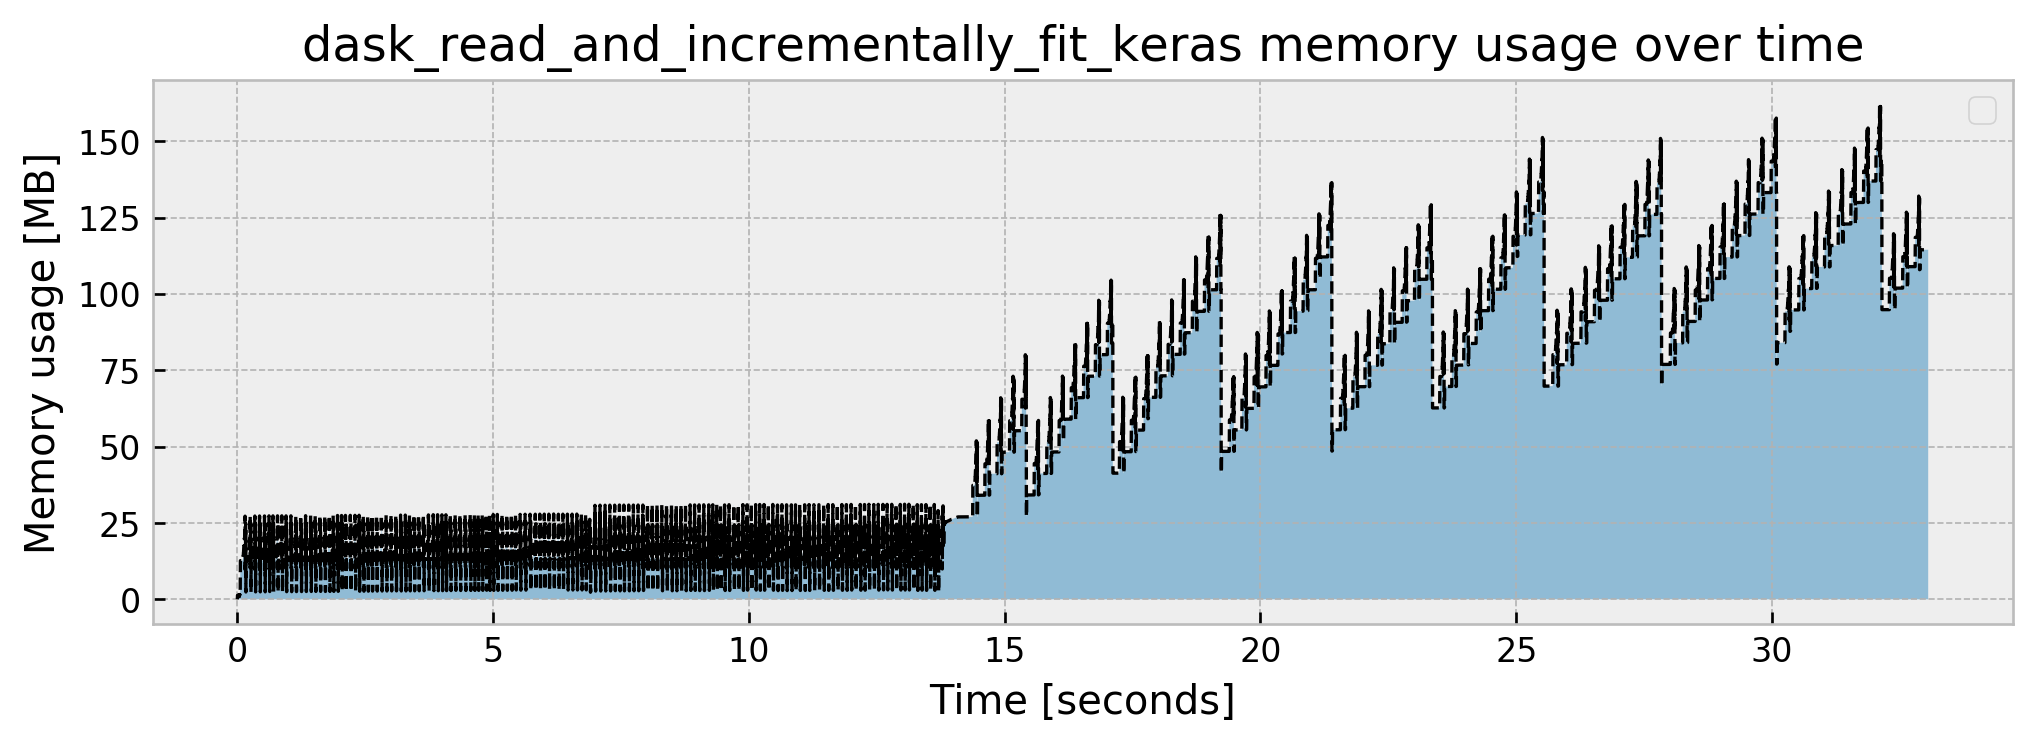

In [22]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
tf.keras.backend.set_floatx('float64')

class KerasWrapper:
    def __init__(self, model, feat_mean, feat_std):
        self.model = model
        self.feat_mean = feat_mean
        self.feat_std = feat_std
        
    def predict_proba(self, X):
        
        preds = self.model.predict((X - self.feat_mean)/self.feat_std)
        return np.c_[preds, preds]
        
# using a function so we can track memory usage
@track_memory_use(close=False, return_history=True)
def dask_read_and_incrementally_fit_keras(blocksize):
    
    # reading df with dask
    df_train = dd.read_csv('./train.csv', blocksize=blocksize)
    
    # creating keras model
    model = Sequential([Dense(16, activation='relu'),
                        Dropout(0.25),
                        Dense(16, activation='relu'),
                        Dropout(0.25),
                        Dense(16, activation='relu'),
                        Dropout(0.25),
                        Dense(1, activation='sigmoid')])
    model.compile(loss='binary_crossentropy')
    
    # getting mean and std for dataset to normalize features
    feat_mean = df_train.drop('isFraud', axis=1).mean().compute(scheduler='synchronous')
    feat_std = df_train.drop('isFraud', axis=1).std().compute(scheduler='synchronous')
    
    # loop for number of partitions
    for i in range(df_train.npartitions):
        
        # getting one partition
        part = df_train.get_partition(i).compute(scheduler='synchronous')
        
        # splitting
        X_part = (part.drop('isFraud', axis=1) - feat_mean)/feat_std
        y_part = part['isFraud']
        
        # running partial fit
        model.fit(X_part, y_part, batch_size=512)
    
    return KerasWrapper(model, feat_mean, feat_std)

model, mem_history_1 = dask_read_and_incrementally_fit_keras(blocksize=5e6)

No handles with labels found to put in legend.


Model result is: 0.9833

Current memory usage: 318.801547
Peak memory usage: 358.292797


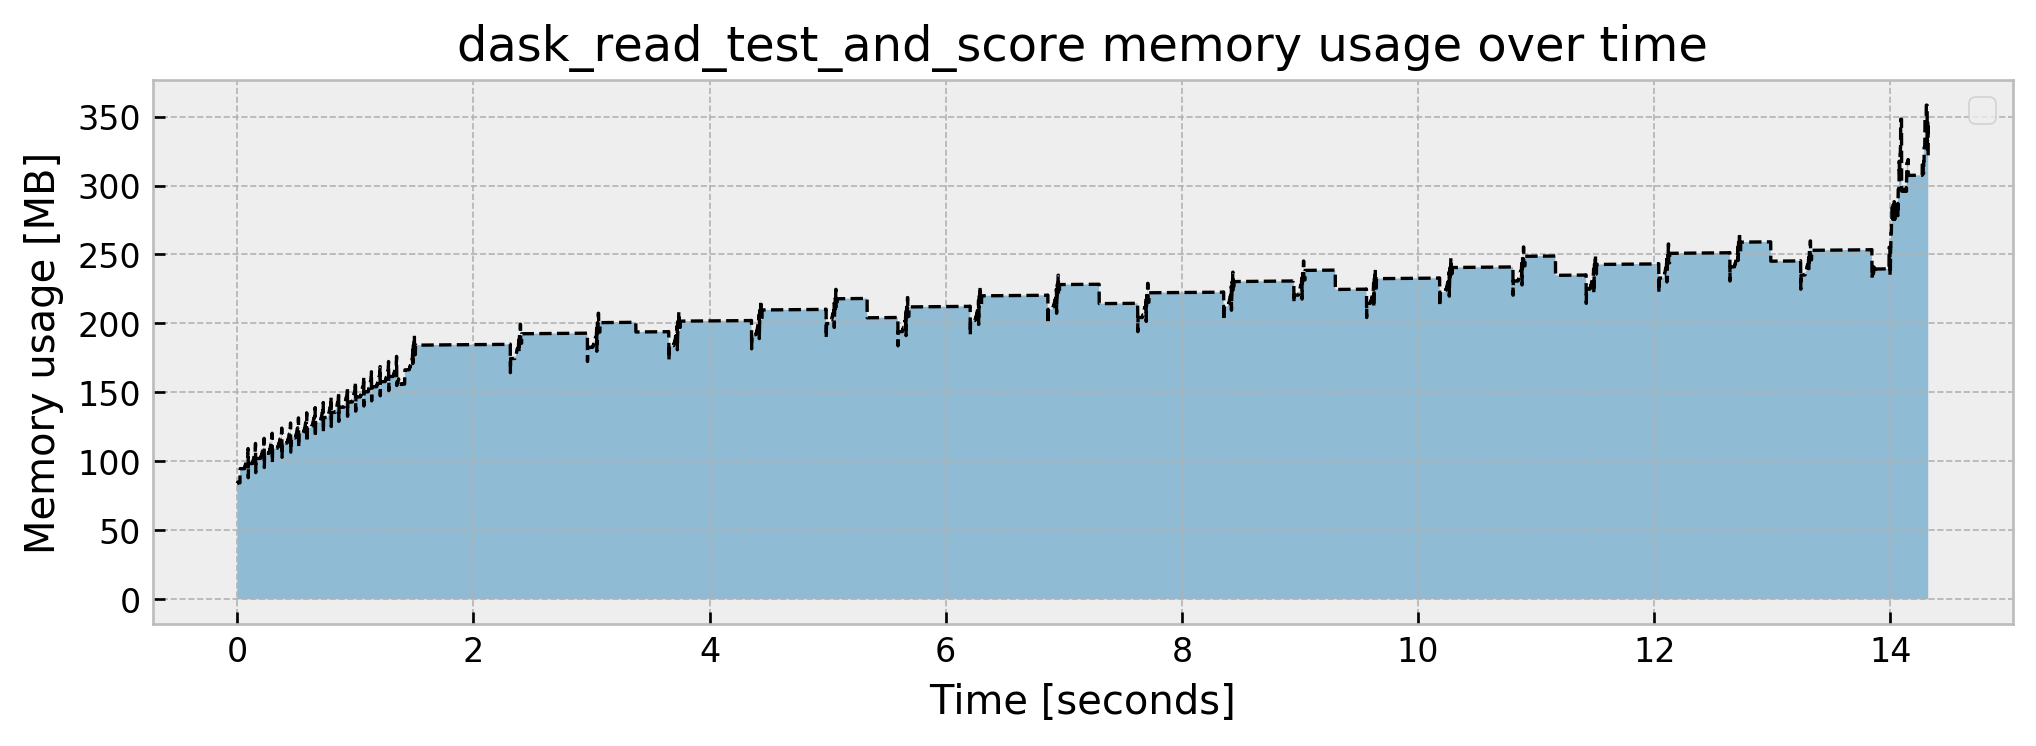

In [23]:
_, mem_history_2 = dask_read_test_and_score(model, blocksize=5e6)

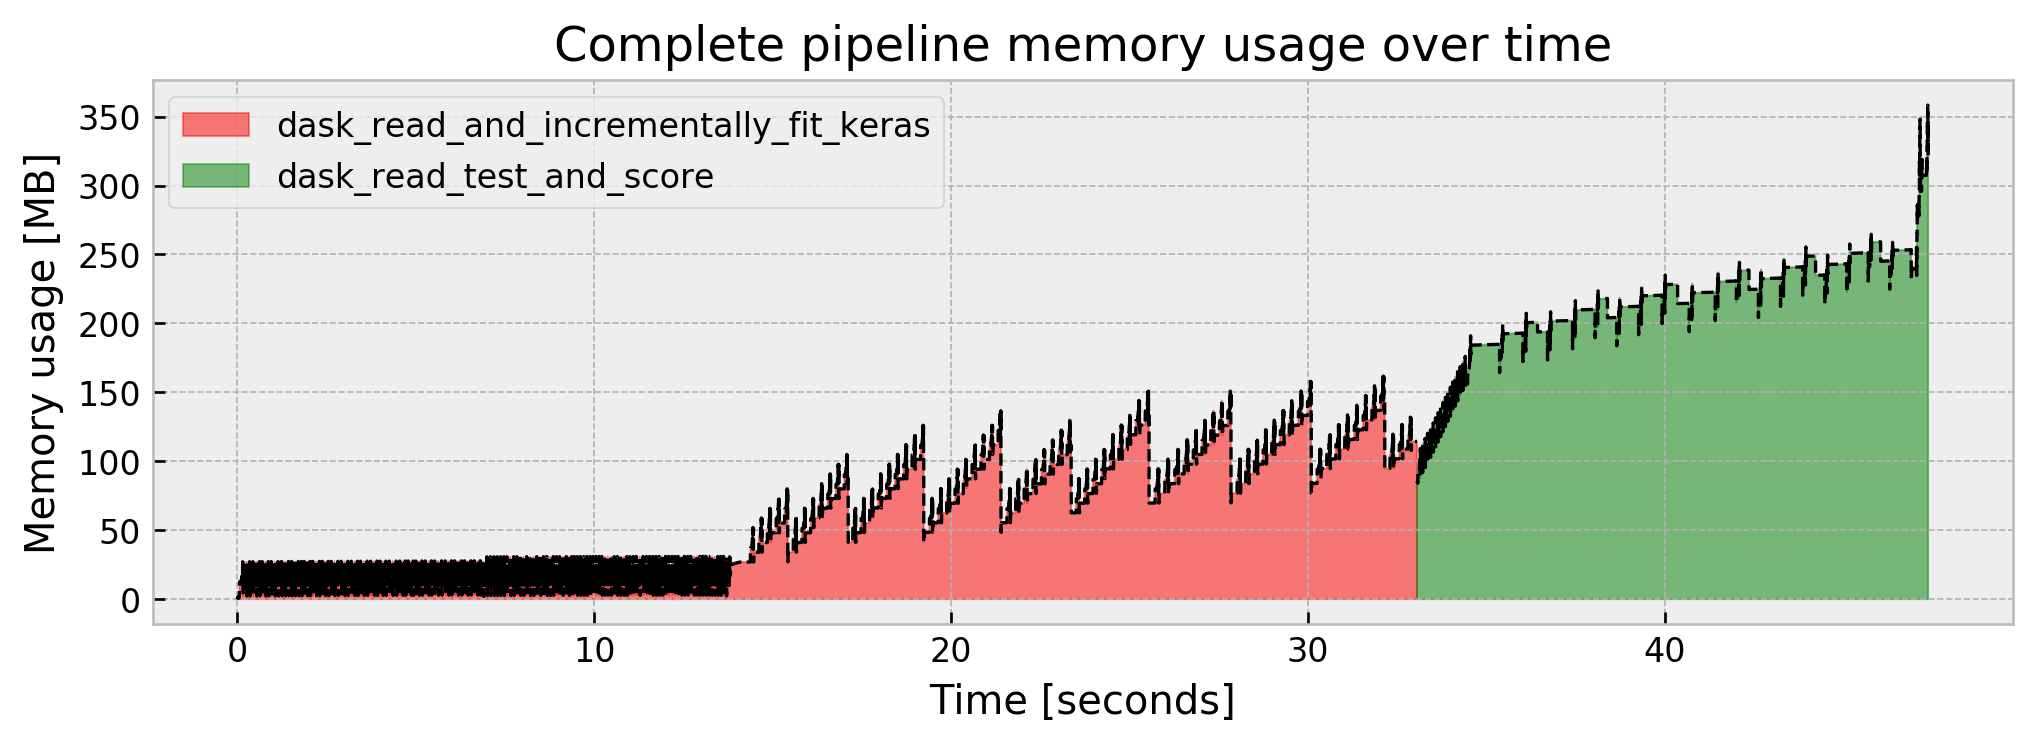

In [24]:
# putting memory usage together
total_mem_use_5 = pd.concat([
    pd.DataFrame({'history': mem_history_1, 'step': 'dask_read_and_incrementally_fit_keras', 'color': 'red', 'offset':0}),
    pd.DataFrame({'history': mem_history_2, 'step': 'dask_read_test_and_score', 'color': 'green', 'offset':len(mem_history_1)}),
])

# plotting
plt.figure(figsize=(10,3), dpi=120)
for step, group in total_mem_use_5.groupby('step'):
    plot_memory_use(history=group['history'].values, 
                    fn_name='Complete pipeline', 
                    open_figure=False, 
                    offset=group['offset'].unique(),
                    color=group['color'], 
                    label=step)

We get an AUC of `0.9833`, around 45s of runtime, and 360 MB of peak memory. It seems like a common ground between memory usage, performance, and runtime.

## Final comparison

I shouldn't leave you without a plot with a final comparison of our tricks:

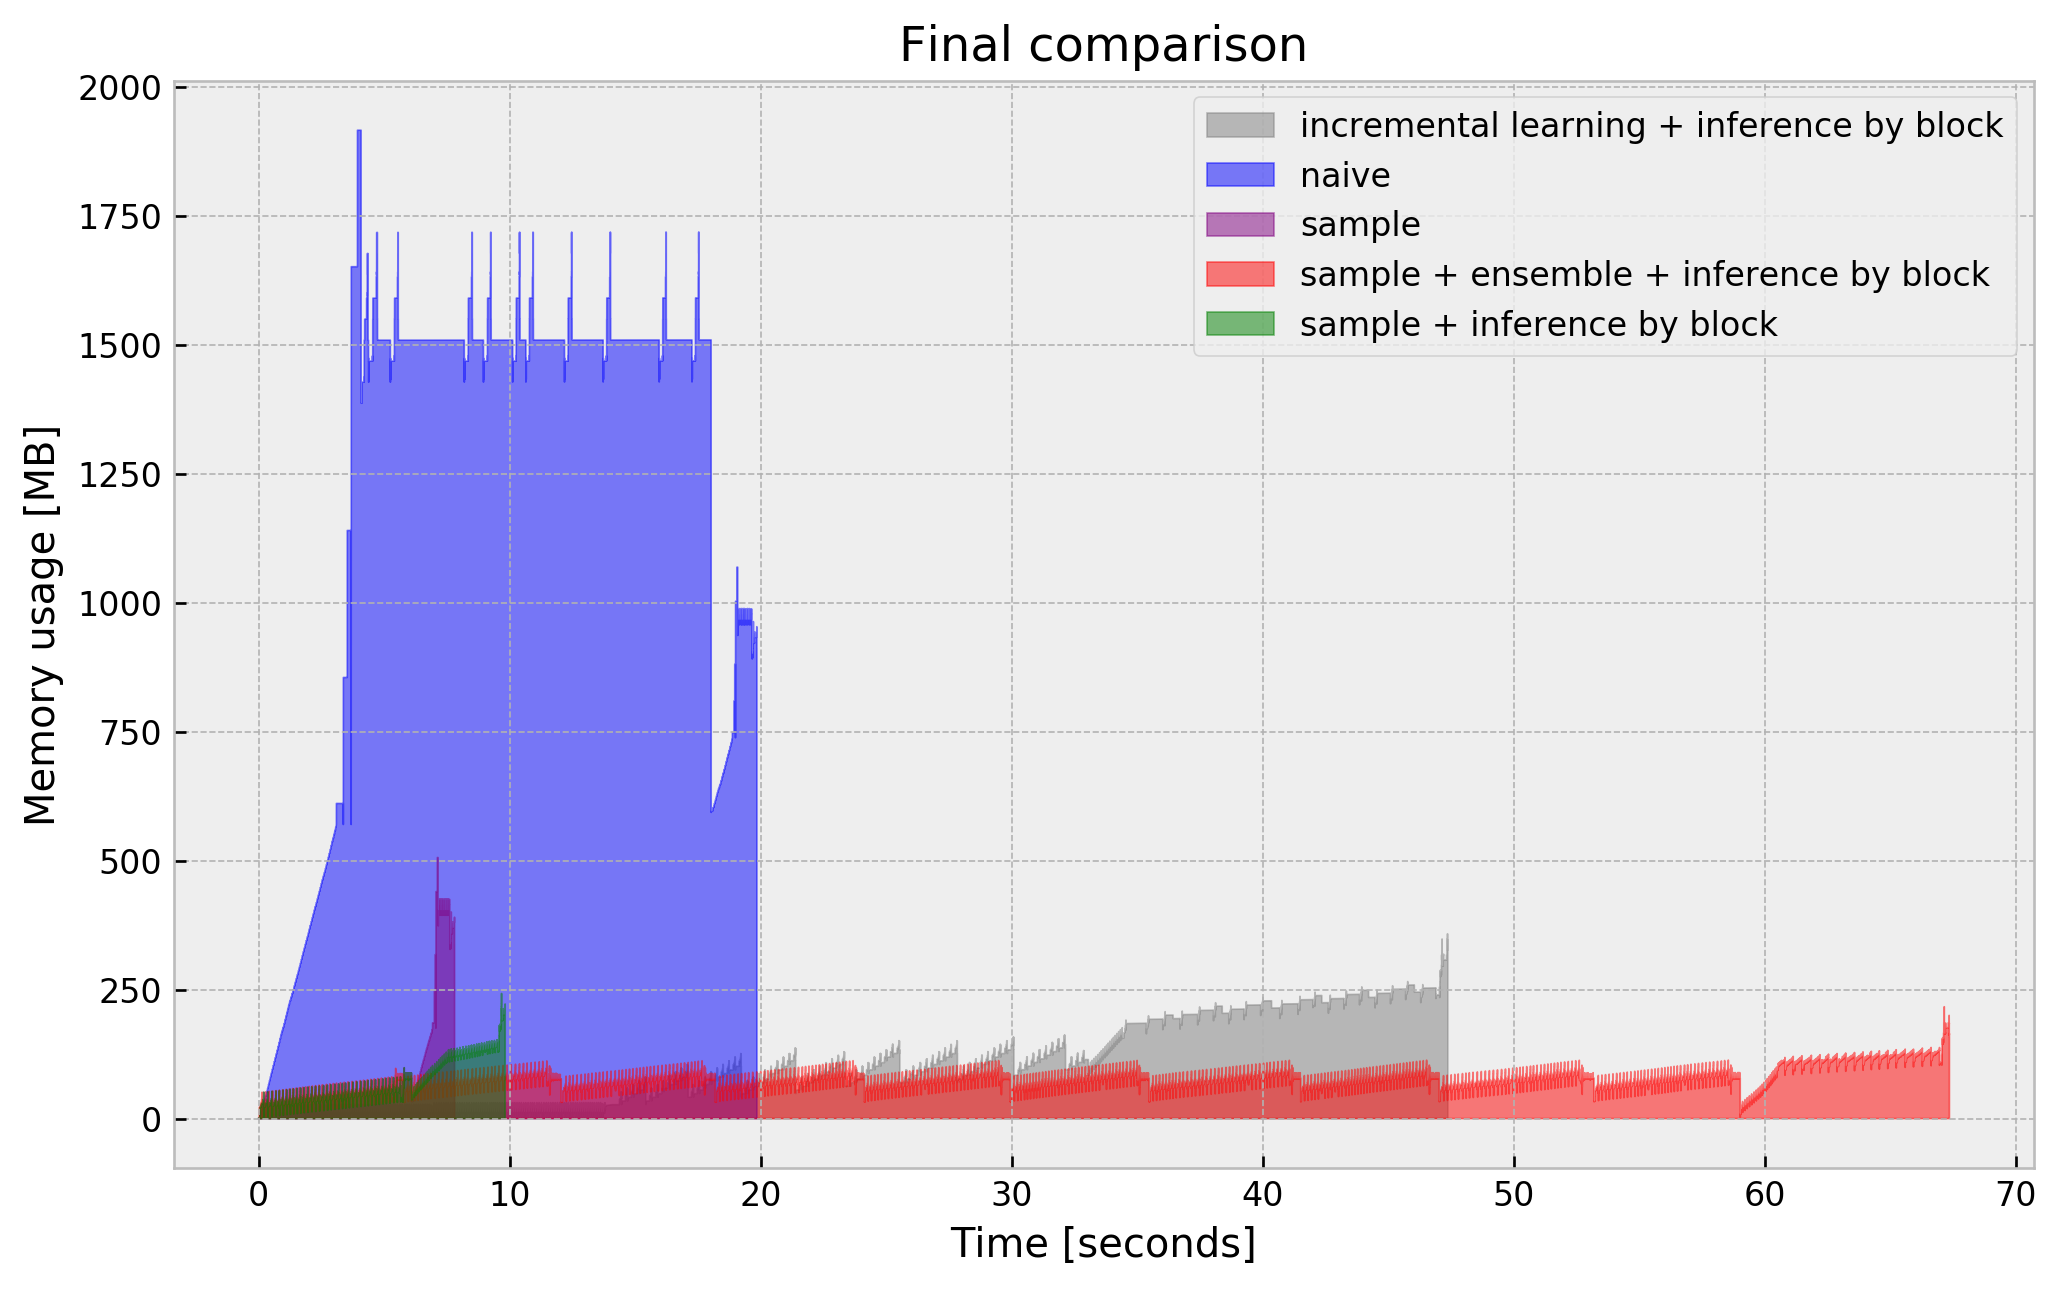

In [44]:
# putting memory usage together
total_mem_use_final = pd.concat([
    pd.DataFrame({'history': total_mem_use['history'], 'step': 'naive', 'color': 'blue', 'offset':0}),
    pd.DataFrame({'history': total_mem_use_2['history'], 'step': 'sample', 'color': 'purple', 'offset':0}),
    pd.DataFrame({'history': total_mem_use_4['history'], 'step': 'sample + inference by block', 'color': 'green', 'offset':0}),
    pd.DataFrame({'history': total_mem_use_3['history'], 'step': 'sample + ensemble + inference by block', 'color': 'red', 'offset':0}),
    pd.DataFrame({'history': total_mem_use_5['history'], 'step': 'incremental learning + inference by block', 'color': 'gray', 'offset':0}),

])

SAMPLING_TIME = 0.001

# plotting
plt.figure(figsize=(10,6), dpi=120)
for step, group in total_mem_use_final.groupby('step'):
    plot_memory_use_2(history=group['history'].values, 
                    fn_name='Complete pipeline', 
                    open_figure=False, 
                    offset=group['offset'].unique(),
                    color=group['color'], 
                    label=step)

## Final remarks

I'll end the post here, but there's a lot more tricks to try:

* Test different sample sizes (we were very agressive with 5%)
* Run a feature selection method on a sample, drop unused features on the full dataframe and fit model (using dask). This should save orders of magnitude of memory on high dimensional datasets.
* Solve pandas "spike" problem. Remember that pandas had a peak meamory use of double the size of the dataframe? This also deteriorates dask performance as it is running the same pandas over its partitions and showing the same spiky behavior.
* Use Dask-ML. It is build on top of `sklearn` and shares a common interface with, same as `dask.dataframe` and pandas. It has the "incremental scoring" capability ready for sklearn models.
* many more that I'll remember eventually!

I hope this post helps you! Full code available [here]().